# Particle Categorical

In [8]:
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

import tensorflow.keras as keras
import tensorflow.keras.backend as K
# from tensorflow.keras.layers import Input, Dense, Activation, BatchNormalization
# from tensorflow.keras.layers import Conv1D
# from tensorflow.keras.layers import Flatten, Reshape, Lambda
# from tensorflow.keras.utils import plot_model
# from tensorflow.keras import Model

import os
import os.path as osp
import sys

import numpy as np
#from scipy import linalg as LA

import matplotlib
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

from utils.tf_sinkhorn import ground_distance_tf_nograd, sinkhorn_knopp_tf_scaling_stabilized_class
import utils.VAE_model_tools
from utils.VAE_model_tools import build_and_compile_annealing_vae, betaVAEModel, reset_metrics

import pandas
import matplotlib.pyplot as plt

import h5py
import pickle


1 Physical GPUs, 1 Logical GPUs


In [3]:
def create_dir(dir_path):
    ''' Creates a directory (or nested directories) if they don't exist.
    '''
    if not osp.exists(dir_path):
        os.makedirs(dir_path)

    return dir_path

output_dir = './data/'

### Define VAE

## Generate training data

Input data is 2D, generated in the shape of a banana (plotted below) defined by two gaussians with widths 1 and 0.1. The VAE will be tasked with reconstructing the 2D location of the input points, using euclidean distance as the reconstruction error. The latent space is 2D, so can in principle easily encode everything about the input. This will be regulated by the variational latent space

In [4]:
# path to file
fn =  '/home/jcollins/projects/EMD_VAE/in_data/monoW-data.h5'

In [5]:
# Option 1: Load everything into memory
df = pandas.read_hdf(fn,stop=1000000)
print(df.shape)
print("Memory in GB:",sum(df.memory_usage(deep=True)) / (1024**3)+sum(df.memory_usage(deep=True)) / (1024**3))

(1000000, 150)
Memory in GB: 2.250075340270996


In [6]:
data = df.values.reshape((-1,50,3))

HT = np.sum(data[:,:,0],axis=-1)
data[:,:,0] = data[:,:,0]/HT[:,None]

sig_input = np.zeros((len(data),50,5))
sig_input[:,:,:2] = data[:,:,:2]
sig_input[:,:,2] = np.cos(data[:,:,-1])
sig_input[:,:,3] = np.sin(data[:,:,-1])
sig_input[:,:,4] = np.log(data[:,:,0]+1e-8)

data_x = sig_input
data_y = data


train_x = data_x[:300000]
train_y = data_y[:300000]
valid_x = data_x[300000:400000]
valid_y = data_y[300000:400000]

<ipython-input-6-dbd7c0f52e79>:4: RuntimeWarning: invalid value encountered in true_divide
  data[:,:,0] = data[:,:,0]/HT[:,None]


In [9]:
experiment_name = 'W-test'
train_output_dir = create_dir(osp.join(output_dir, experiment_name))
vae, encoder, decoder = build_and_compile_annealing_vae(optimizer=keras.optimizers.Adam(lr=0.001,clipnorm=0.1),
                                    encoder_conv_layers = [512,512,512,512],
                                    dense_size = [512,512,512,512],
                                    decoder = [512,512,512,512],
                                    numItermaxinner = 10,
                                    numIter=10,
                                    reg_init = 1.,
                                    reg_final = 0.01,
                                    stopThr=1e-3,
                                    num_inputs=5,
                                    num_particles_in=50)

batch_size=100
save_period=2

reduceLR = keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.1, patience=2, verbose=1, mode='auto', min_delta=1e-4, cooldown=0, min_lr=0)
modelcheckpoint = keras.callbacks.ModelCheckpoint(train_output_dir + '/model_weights_{epoch:02d}.hdf5', save_freq = save_period*5000, save_weights_only=True)
reset_metrics_inst = reset_metrics()

callbacks=[tf.keras.callbacks.CSVLogger(train_output_dir + '/log.csv', separator=",", append=True),
            reduceLR,
            modelcheckpoint,
            reset_metrics_inst]

Instructions for updating:
Do not pass `graph_parents`.  They will  no longer be used.
Model: "VAE"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, 50, 5)]      0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 50, 512)      3072        inputs[0][0]                     
__________________________________________________________________________________________________
re_lu (ReLU)                    (None, 50, 512)      0           conv1d[0][0]                     
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 50, 512)      262656      re_lu[0][0]                      
_________

In [31]:
def kl_loss(z_mean, z_log_var):
    return -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))

In [14]:
batch_size=100
save_period=2
callbacks=[]

vae.beta.assign(0.01)
numbatches = 5000

K.set_value(vae.optimizer.lr,1e-4)
epochs = 1000


history = vae.fit(x=train_x[:10], y=train_y[:10], batch_size=10,
                epochs=1,verbose=1,#initial_epoch=int(vae.optimizer.iterations/numbatches),
                #validation_data = (valid_x[:10*batch_size],valid_y[:10*batch_size]),
                callbacks = callbacks
              )

# tf.saved_model.save(vae, train_output_dir + '/mymodel.hdf5')

Epoch 1/1000
1/1 [==============================] - 0s 2ms/step - loss: 47580.1602 - recon_loss: 4.6183 - KL loss: 1397.1456 - beta: 0.0100
Epoch 2/1000
1/1 [==============================] - 0s 1ms/step - loss: 43303.0508 - recon_loss: 4.2311 - KL loss: 992.1614 - beta: 0.0100
Epoch 3/1000
1/1 [==============================] - 0s 1ms/step - loss: 40672.6250 - recon_loss: 3.9854 - KL loss: 818.9852 - beta: 0.0100
Epoch 4/1000
1/1 [==============================] - 0s 6ms/step - loss: 39259.5664 - recon_loss: 3.8543 - KL loss: 716.4323 - beta: 0.0100
Epoch 5/1000
1/1 [==============================] - 0s 3ms/step - loss: 38162.3359 - recon_loss: 3.7522 - KL loss: 640.7421 - beta: 0.0100
Epoch 6/1000
1/1 [==============================] - 0s 2ms/step - loss: 37477.5469 - recon_loss: 3.6894 - KL loss: 583.4530 - beta: 0.0100
Epoch 7/1000
1/1 [==============================] - 0s 2ms/step - loss: 36724.9258 - recon_loss: 3.6186 - KL loss: 539.2405 - beta: 0.0100
Epoch 8/1000
1/1 [========

KeyboardInterrupt: 

In [11]:
from pyjet import cluster

def get_clustered_pt_eta_phi(pts, locations,R=0.1):
    weights = pts
    outjet = locations
    myjet = np.zeros((weights.shape[-1]),dtype=([('pT', 'f8'), ('eta', 'f8'), ('phi', 'f8'), ('mass', 'f8')]))
    myjet['pT'] = weights
    myjet['eta'] = outjet[:,0]
    myjet['phi'] = outjet[:,1]
    sequence = cluster(myjet,R=R,p=0)
    jets = sequence.inclusive_jets()
    phis = np.array([np.mod(np.pi+jet.phi,2*np.pi)-np.pi for jet in jets])
#     phis = [jet.phi for jet in jets]
    etas = np.array([jet.eta for jet in jets])
    pts = np.array([jet.pt for jet in jets])
    
    return pts, etas, phis

In [42]:
vae.load_weights('/home/jcollins/projects/EMD_VAE/data/W-test/model_weights_35_1.5.hdf5')
outs_array = [vae.predict(valid_x[:1000]) for j in range(3)]

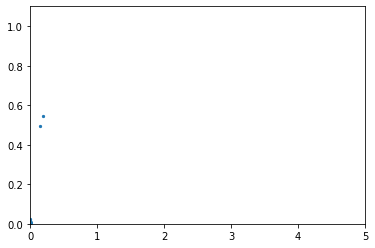

In [45]:
_, z_mean, z_log_var, z = outs_array[0]

KL=kl_loss(z_mean, z_log_var)
sort_kl = np.flip(np.argsort(np.mean(KL,axis=0)))

rms_mean = np.sqrt(np.mean(np.square(z_mean),axis=0))

plt.scatter(np.mean(KL,axis=0),rms_mean,s=5.)

plt.ylim([0,1.1])
plt.xlim([0,5.])
plt.show()

# log_var = outs_array[0][2]
# log_var_means = np.mean(log_var,axis=0)
# means = outs_array[0][1]
# mean_means = np.sqrt(np.mean(np.square(means),axis=0))
# order = np.argsort(log_var_means)

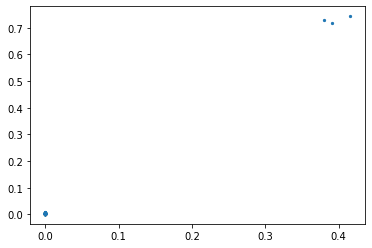

In [41]:
_, z_mean, z_log_var, z = outs_array[0]

KL=kl_loss(z_mean, z_log_var)
sort_kl = np.flip(np.argsort(np.mean(KL,axis=0)))

rms_mean = np.sqrt(np.mean(np.square(z_mean),axis=0))

plt.scatter(np.mean(KL,axis=0),rms_mean,s=5.)
plt.show()

# log_var = outs_array[0][2]
# log_var_means = np.mean(log_var,axis=0)
# means = outs_array[0][1]
# mean_means = np.sqrt(np.mean(np.square(means),axis=0))
# order = np.argsort(log_var_means)

In [33]:
sort_kl

array([ 49,  38,  27,   4,  67,  33,   8,  30,  73,  17,  54,  42,  64,
        41,  39,  84, 116,  40,  94,  37,  23,  13,  75,  12,  22,  51,
       112,  58,  89,  80, 108,  19,  99,  28, 127, 103,  45,  85,  78,
         5,  46,  29,  57,  82,   0,  98,  47,  81,  95, 126,  70,  11,
        18,  63,  53,  44,   7,  88, 104,  77, 102,   1, 106,  92, 105,
        71,  91,  31, 124,  68, 114,  35,   2, 100,  76,  96,   6,  55,
        66,  34, 113, 110, 119,  25, 101,  48,  65,  72,  90, 109,  74,
        83, 117,  21,  60,  36, 125,  86,  97,  15, 120,  56,  59, 107,
        14,  10, 121,  87,  32,  24, 111,  93,   9,  16,   3, 118,  43,
       122,  61,  52, 123,  62,  26,  20,  69, 115,  79,  50])

In [98]:
thresh = 0.01
tagged = np.logical_and(z_bern[:,bernsort_means[0]] < thresh, z_bern[:,bernsort_means[1]] < thresh)
print(np.sum(valid_labels[:10000][tagged])/np.sum(tagged),np.sum(valid_labels[:10000])/10000)

IndexError: boolean index did not match indexed array along dimension 0; dimension is 10000 but corresponding boolean dimension is 1000

In [64]:
for i in range(32):
    tagged = z_bern[:,bernsort_means[i]] < 0.5
    print(i, np.sum(valid_labels[:10000][tagged])/np.sum(tagged),np.sum(valid_labels[:10000])/10000)

0 0.14154912150457807 0.1274
1 0.14562512747297574 0.1274
2 0.12338568935427574 0.1274
3 0.13179033356024505 0.1274
4 0.130465644520159 0.1274
5 0.1259073143495254 0.1274
6 0.12934413378625556 0.1274
7 0.12565229332600933 0.1274
8 0.1286182413981431 0.1274
9 0.12915334352843041 0.1274
10 0.12738767823513586 0.1274
11 0.12850752338348922 0.1274
12 0.12744160633793197 0.1274
13 0.12464358452138492 0.1274
14 0.12604152889829387 0.1274
15 0.12929106931474418 0.1274
16 0.1271078180889116 0.1274
17 0.12974312165862564 0.1274
18 0.12902806652806653 0.1274
19 0.12885662431941924 0.1274
20 0.12821839824039333 0.1274
21 0.12433392539964476 0.1274
22 0.12714249168585315 0.1274
23 0.12522545735635146 0.1274
24 0.12461890243902439 0.1274
25 0.12493709109209863 0.1274
26 0.12304418575541369 0.1274
27 0.1264569494924176 0.1274
28 0.12506303580433686 0.1274
29 0.1276806743522995 0.1274
30 0.12878316104122556 0.1274
31 0.12786640079760717 0.1274


In [18]:
for i in range(20):
    tagged = z_bern[:,bernsort_means[i]] > 0.5
    print(i, np.sum(valid_labels[:10000][tagged])/np.sum(tagged),np.sum(valid_labels[:10000])/10000)

0 0.1008714596949891 0.1292
1 0.11163714111178986 0.1292
2 0.12171581769436997 0.1292
3 0.1282051282051282 0.1292
4 0.12978030919446704 0.1292
5 0.12907830342577487 0.1292
6 0.1300219983790668 0.1292
7 0.12919975565058034 0.1292
8 0.12837218772269166 0.1292
9 0.1296541874936244 0.1292
10 0.12908163265306122 0.1292
11 0.12934815872692032 0.1292
12 0.12908163265306122 0.1292
13 0.12842727550708388 0.1292
14 0.128590411939078 0.1292
15 0.12998568214358763 0.1292
16 0.12846193152784874 0.1292
17 0.12877859477124182 0.1292
18 0.12943461813720478 0.1292
19 0.12854364957527378 0.1292


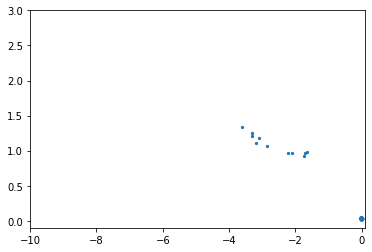

In [99]:
plt.scatter(log_var_means/np.log(10.),mean_means,s=5.)
plt.xlim([-10.,0.1])
plt.ylim([-0.1,3])
plt.show()

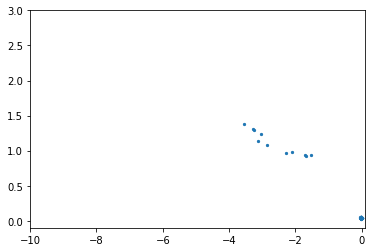

In [75]:
plt.scatter(log_var_means/np.log(10.),mean_means,s=5.)
plt.xlim([-10.,0.1])
plt.ylim([-0.1,3])
plt.show()

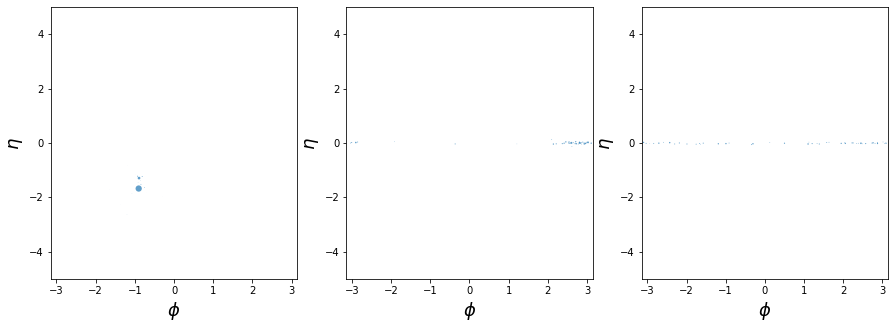

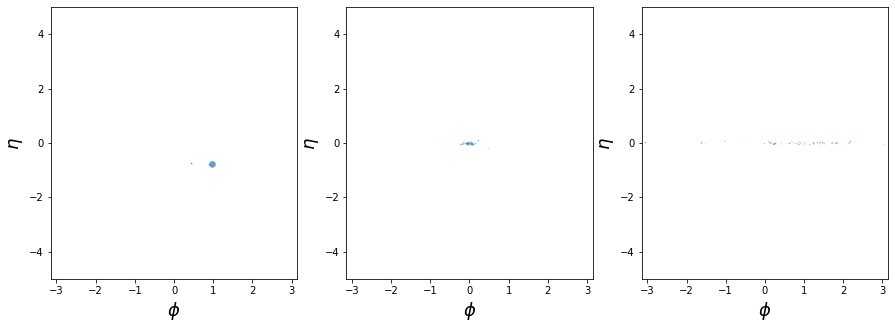

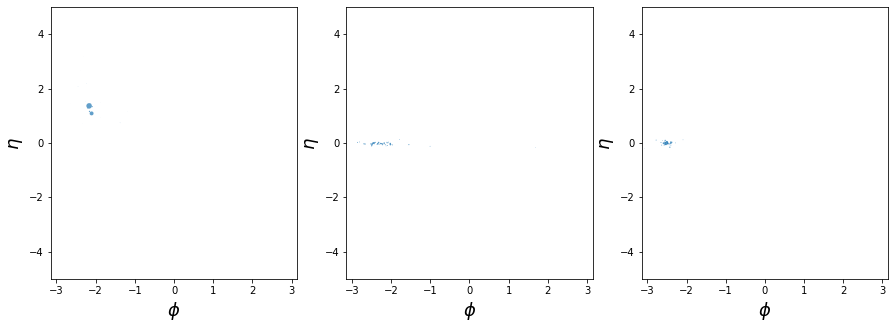

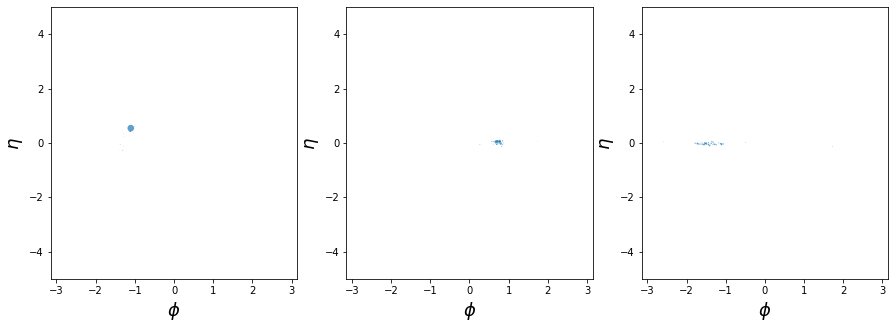

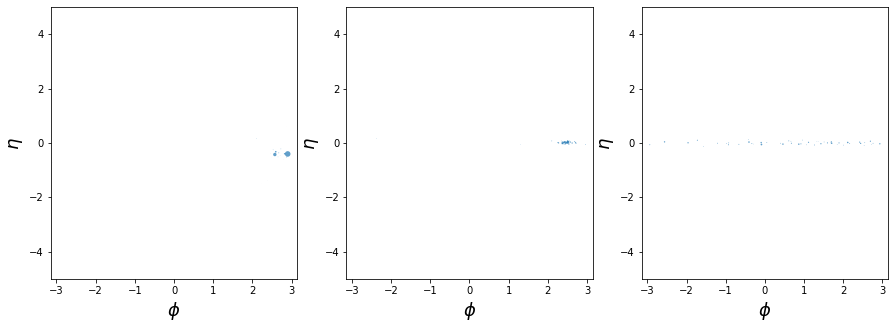

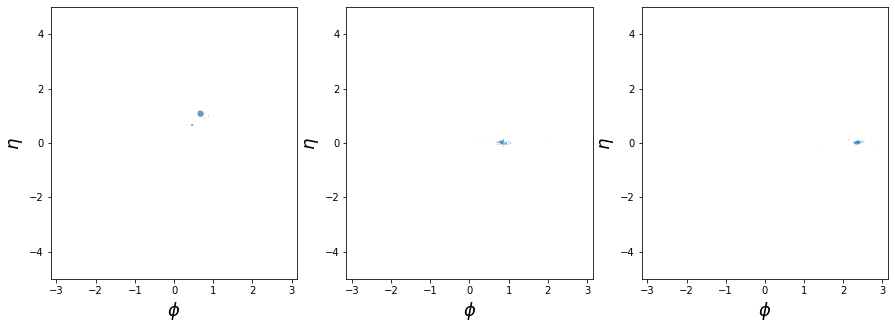

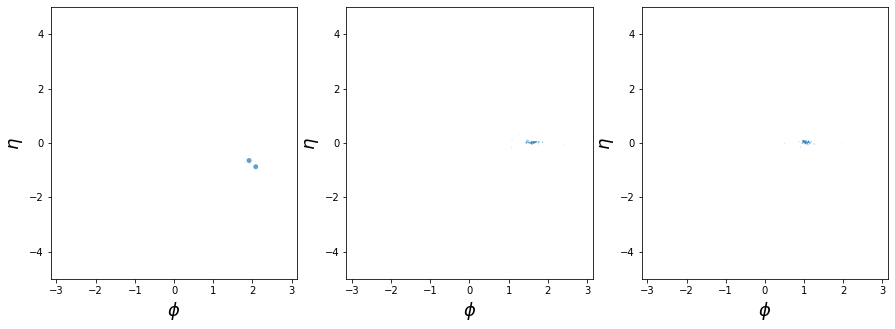

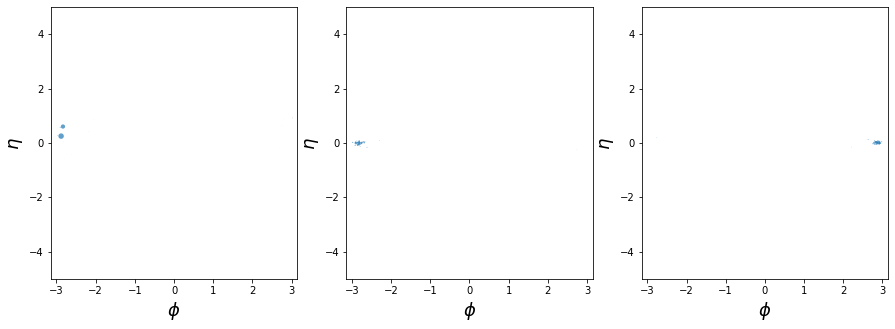

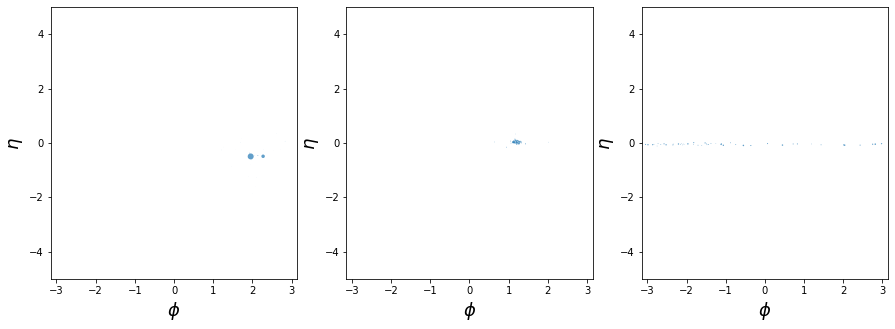

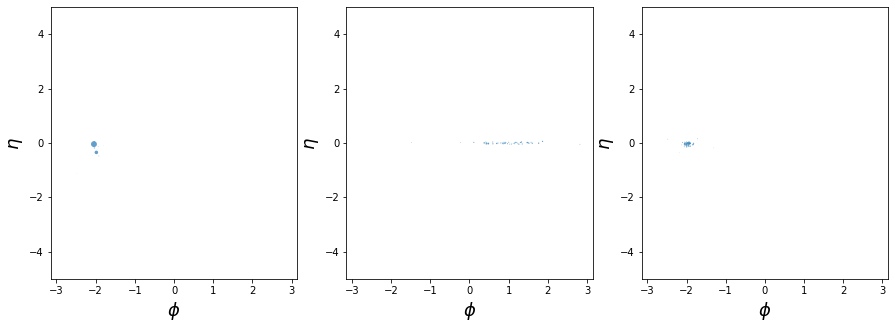

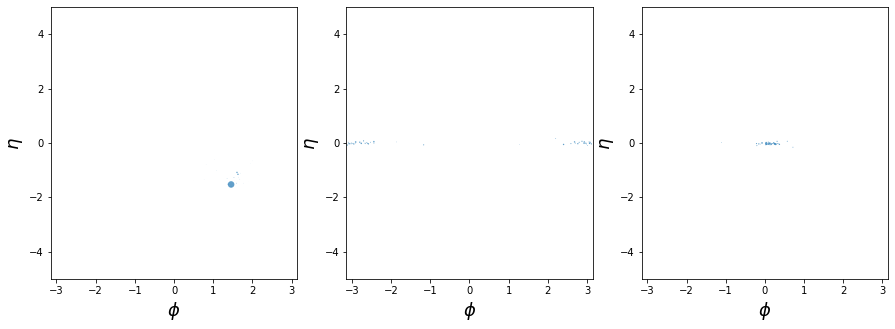

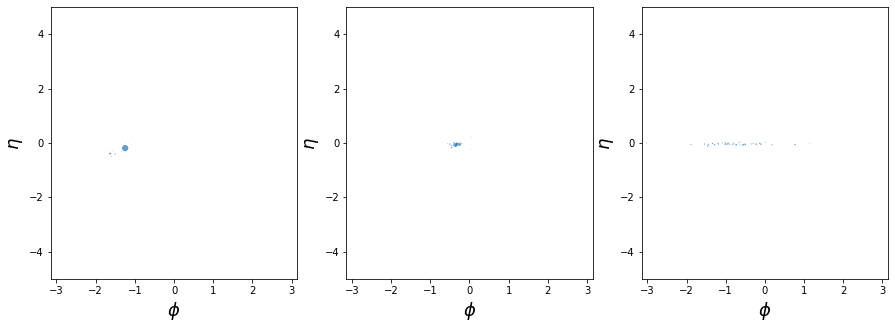

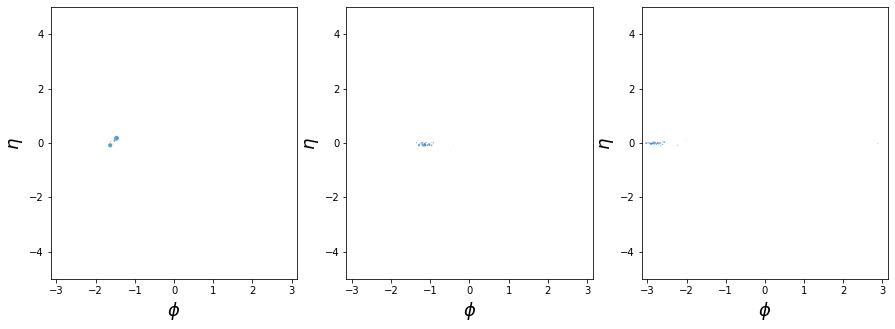

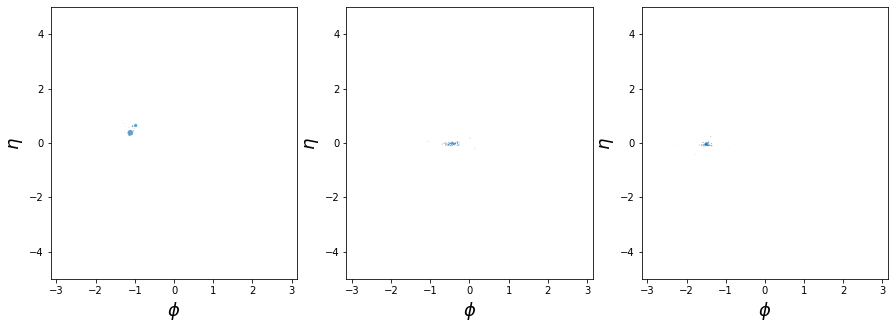

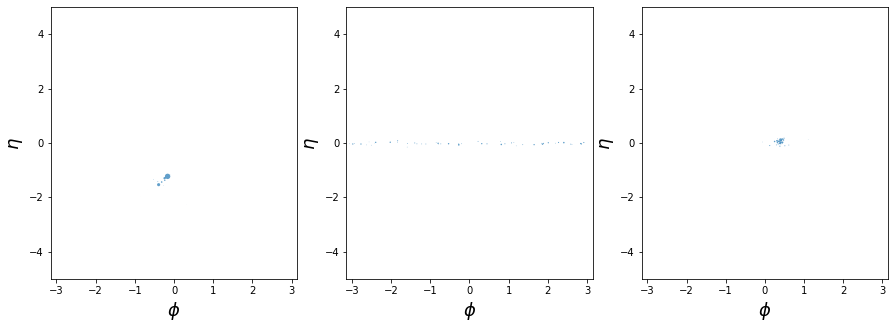

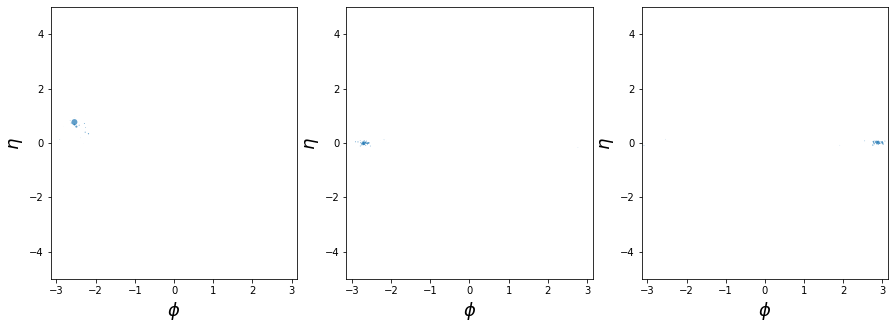

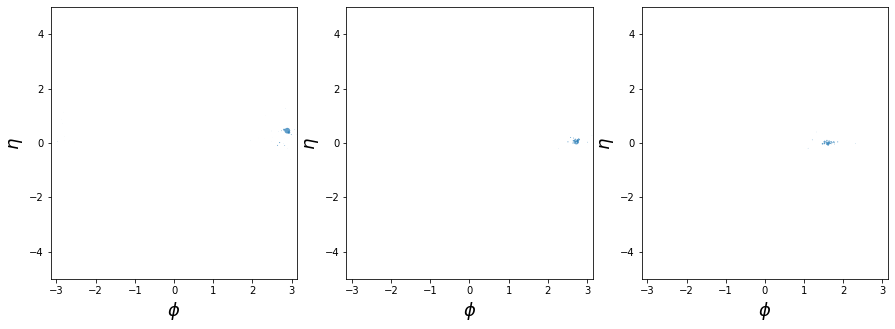

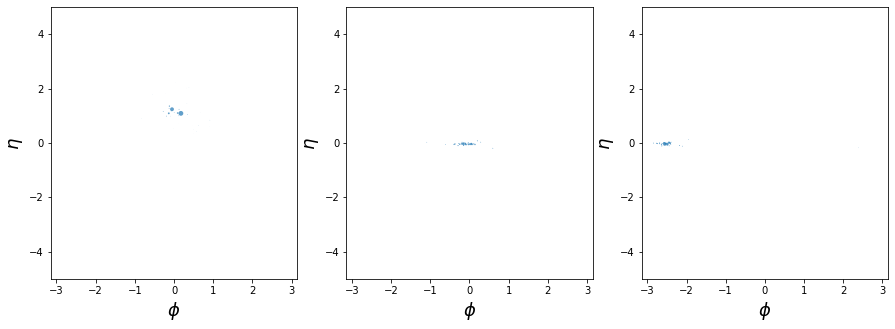

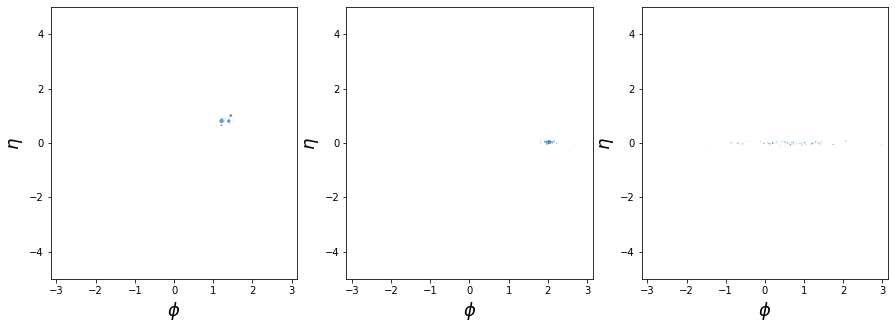

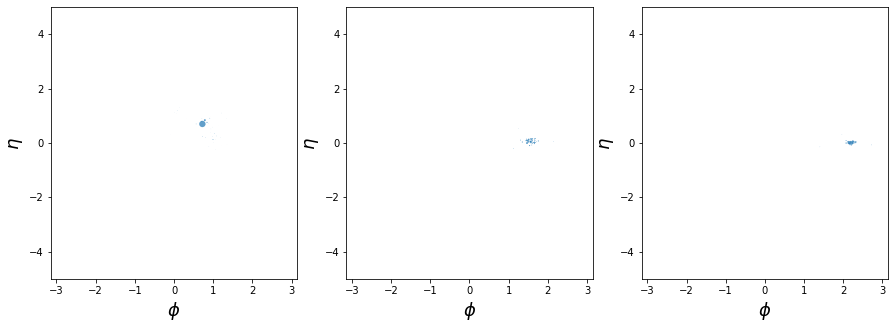

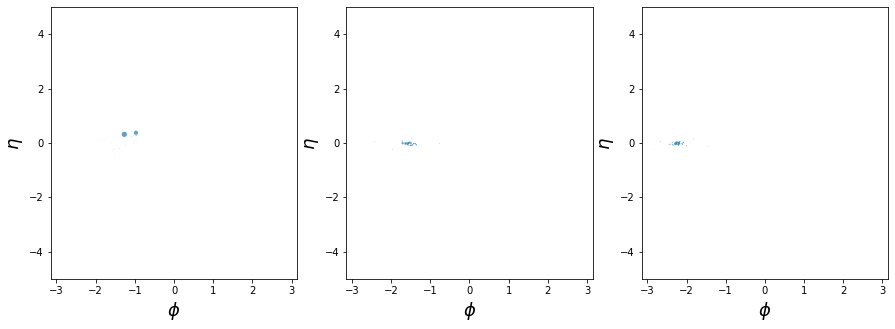

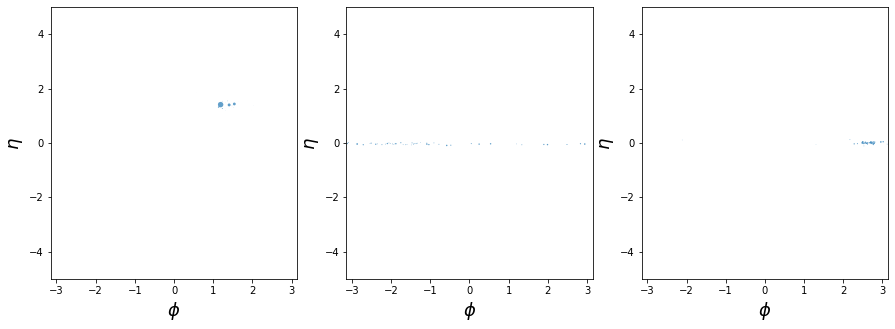

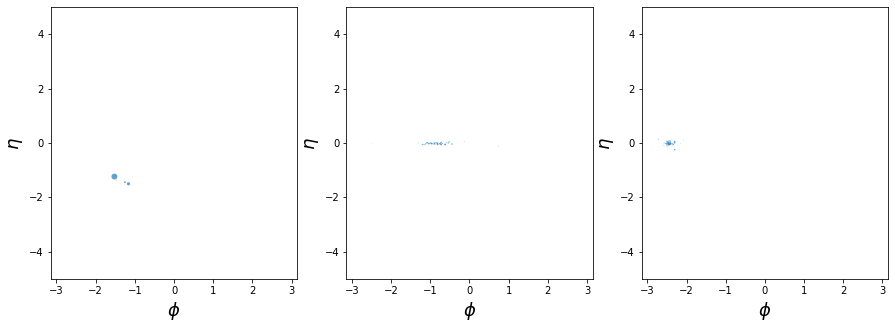

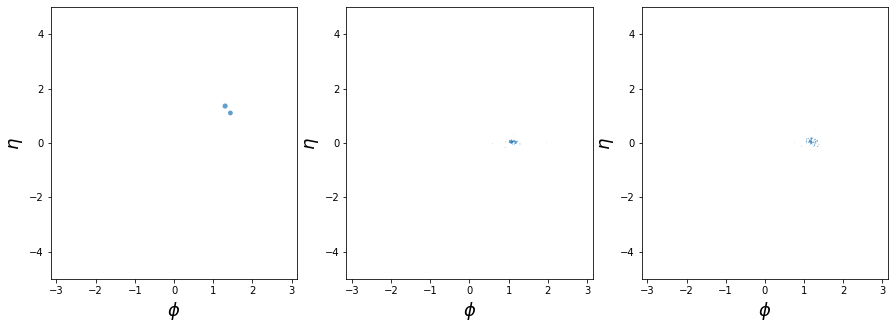

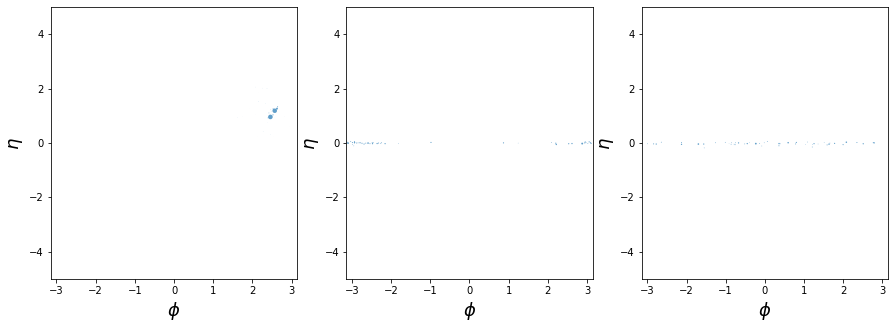

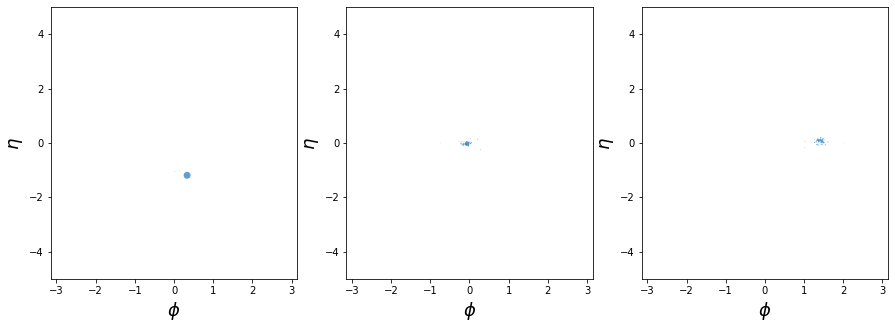

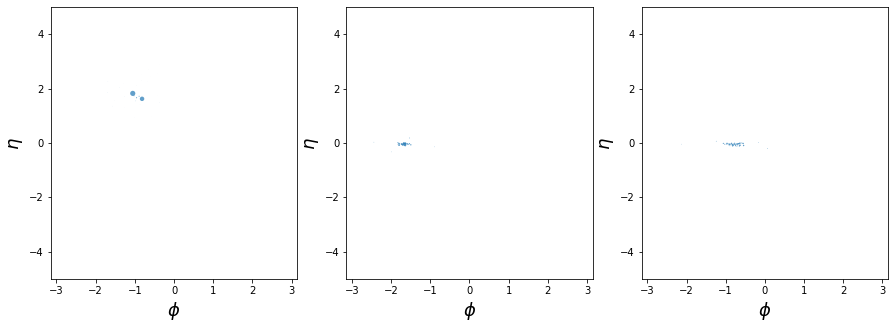

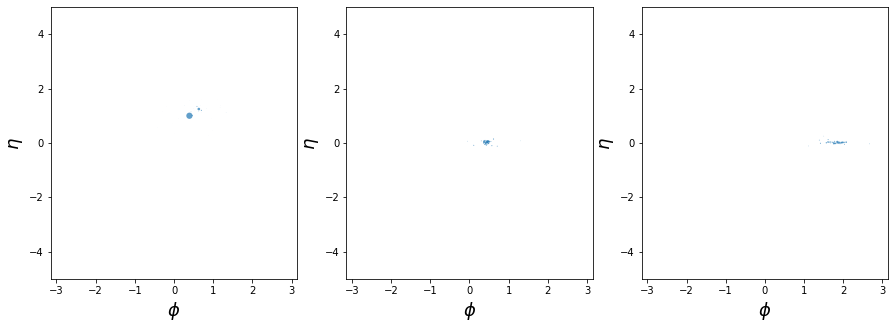

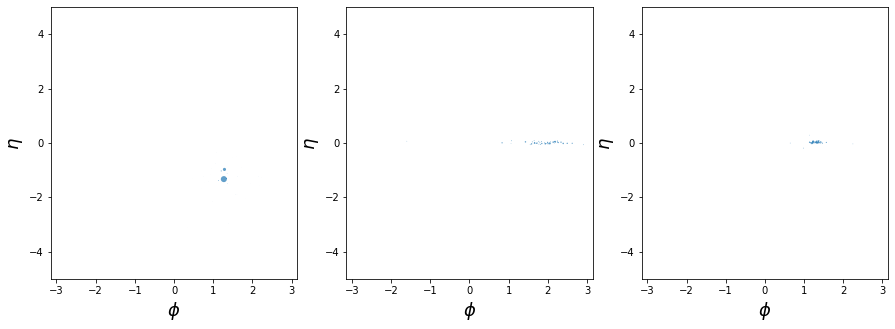

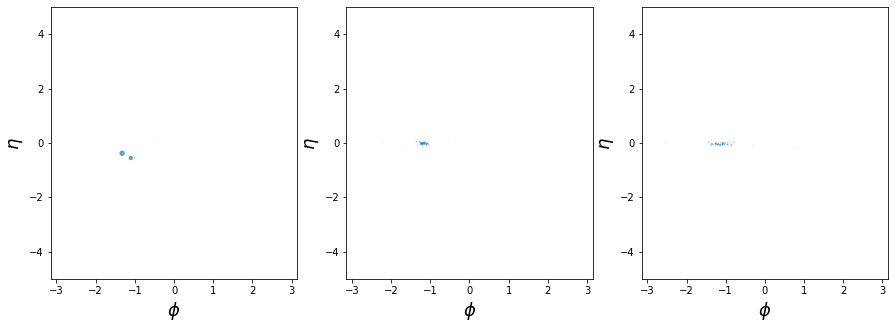

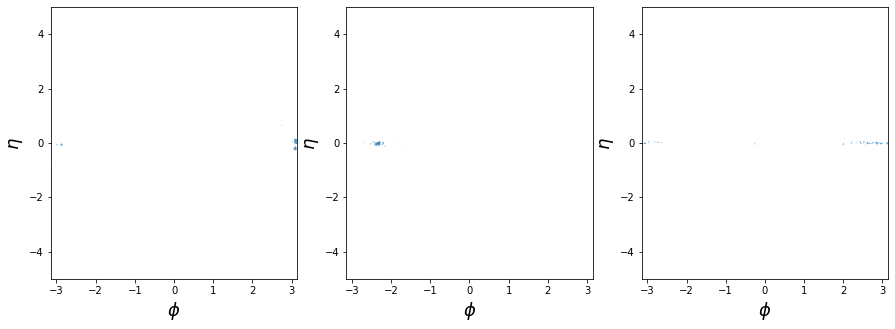

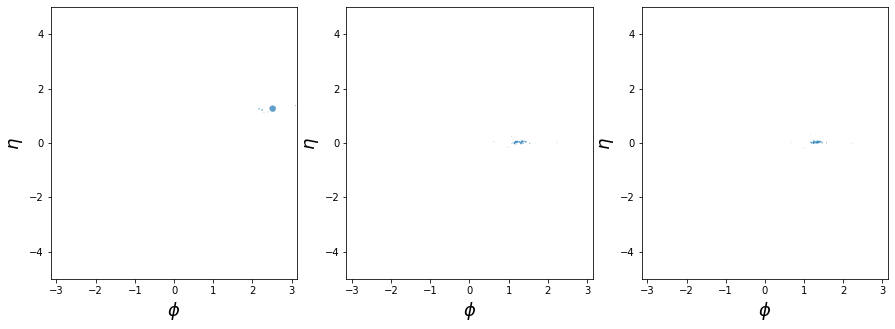

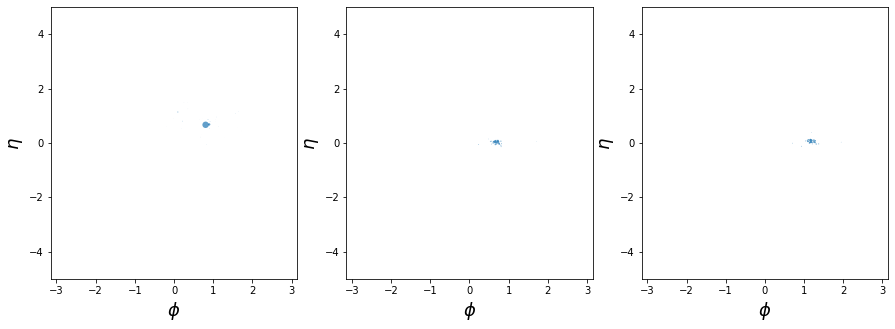

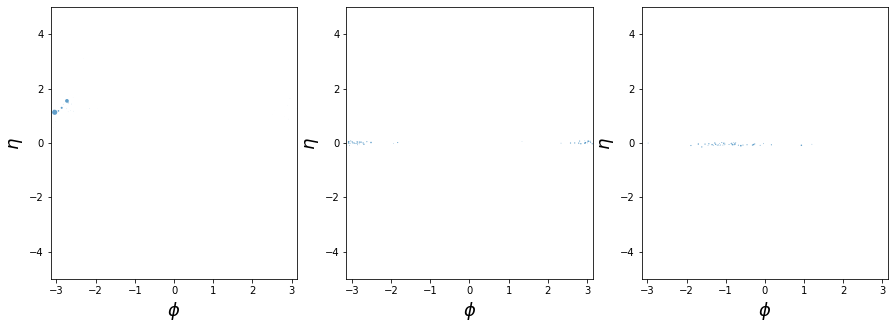

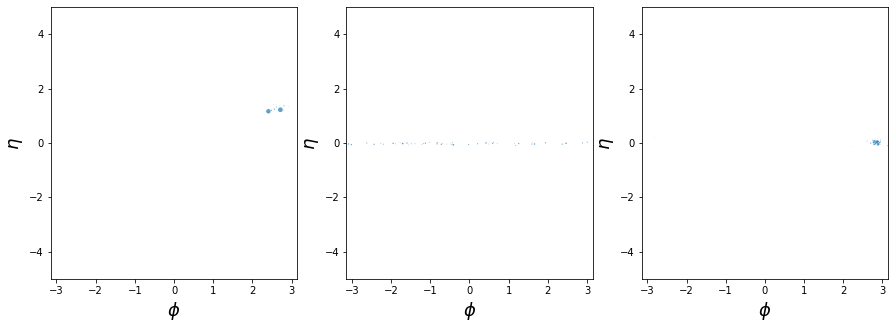

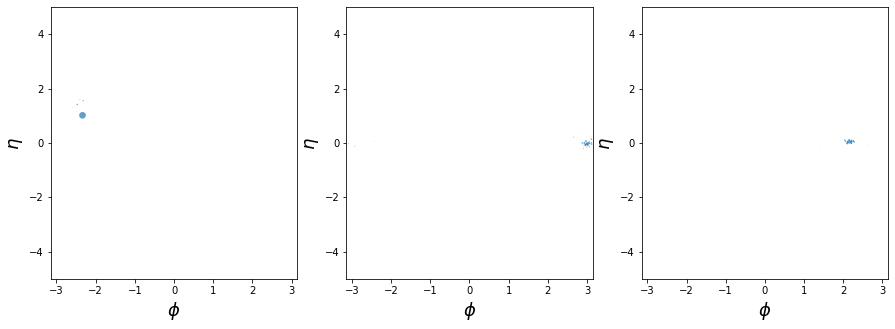

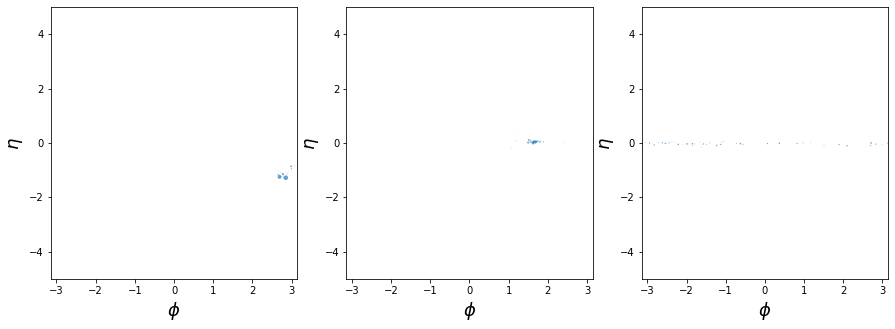

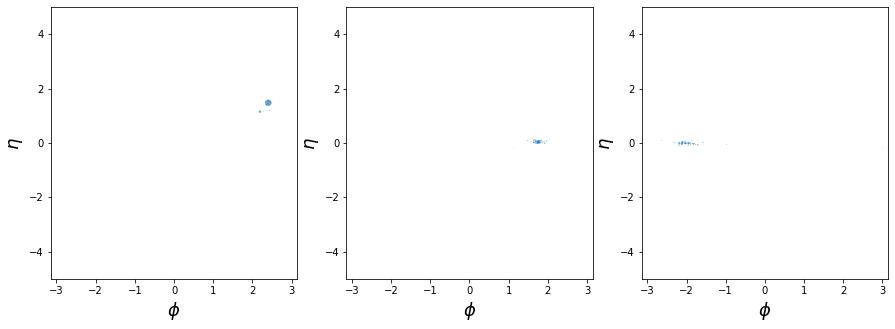

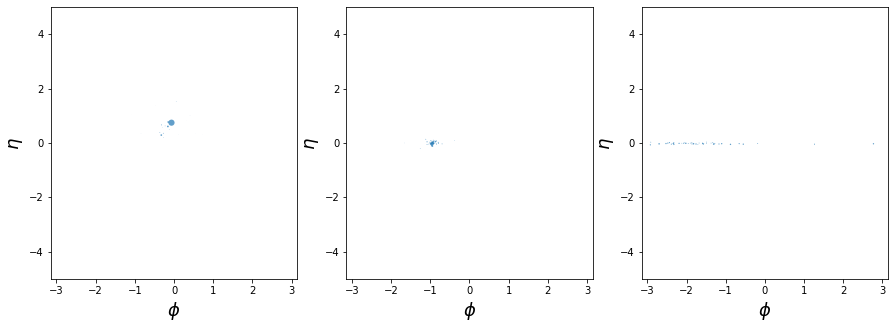

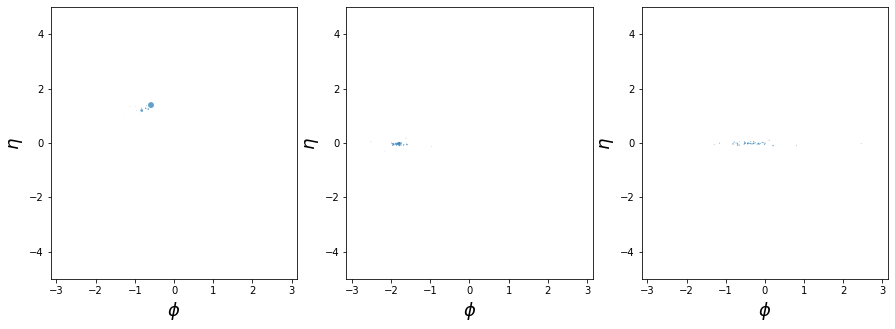

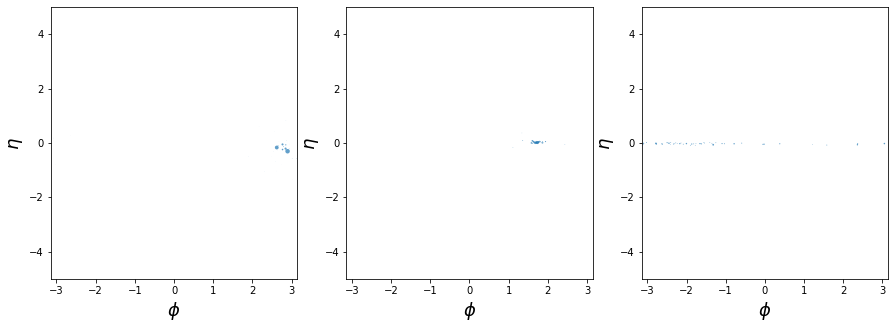

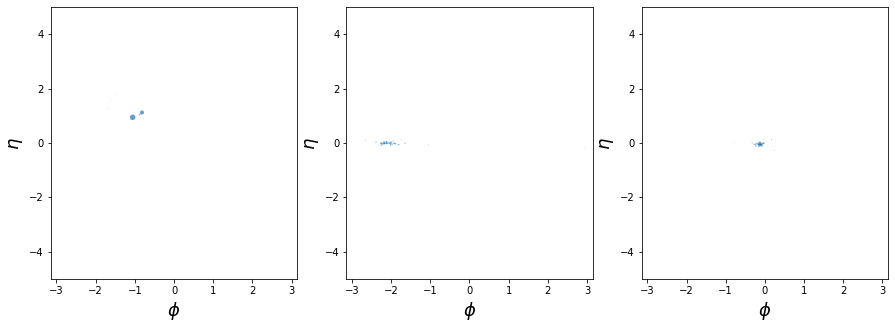

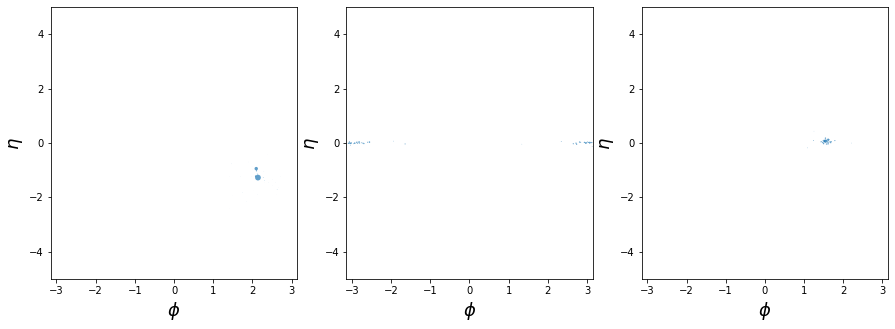

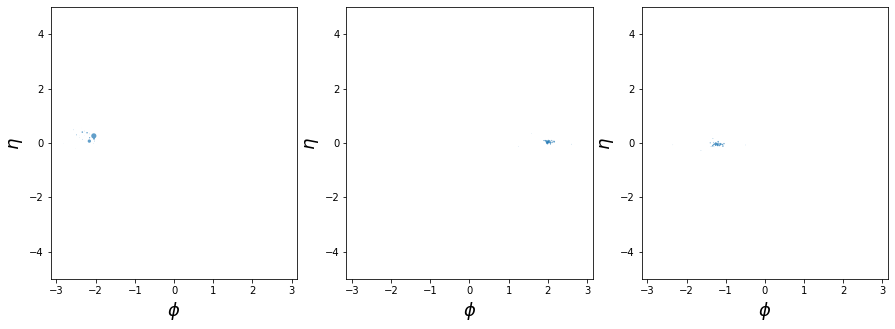

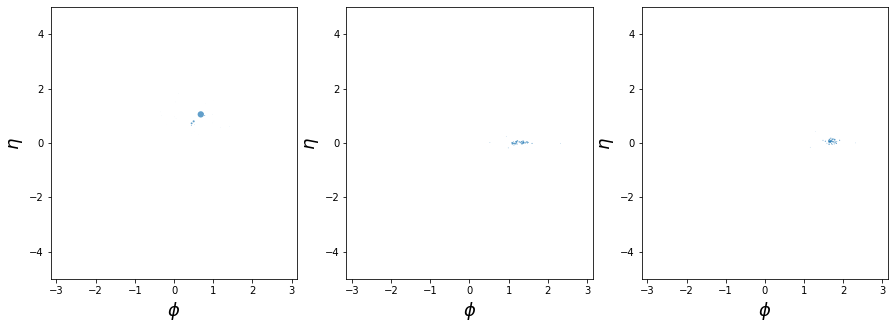

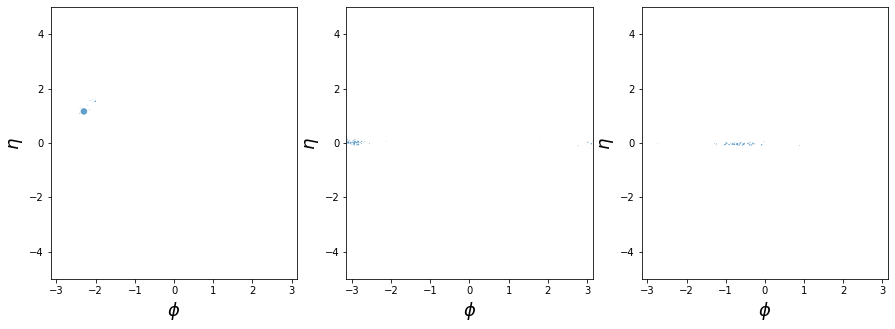

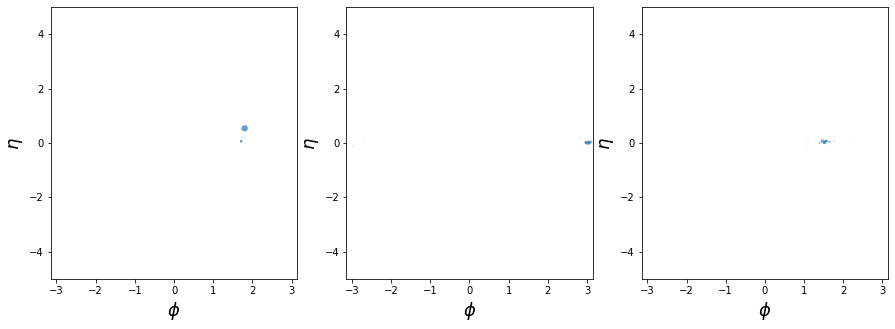

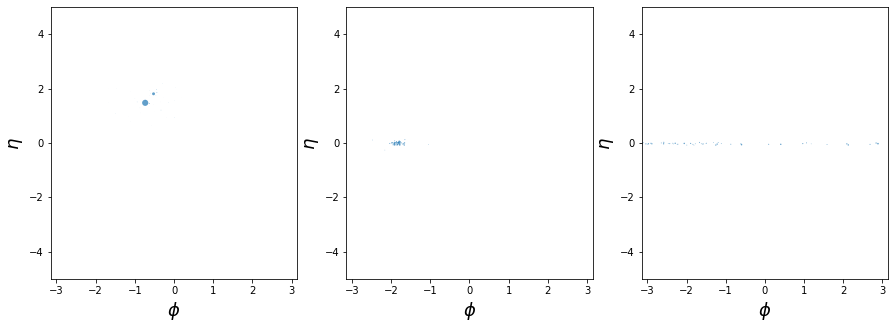

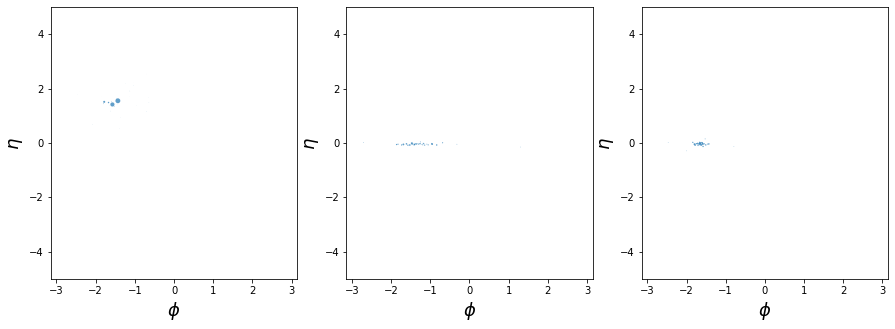

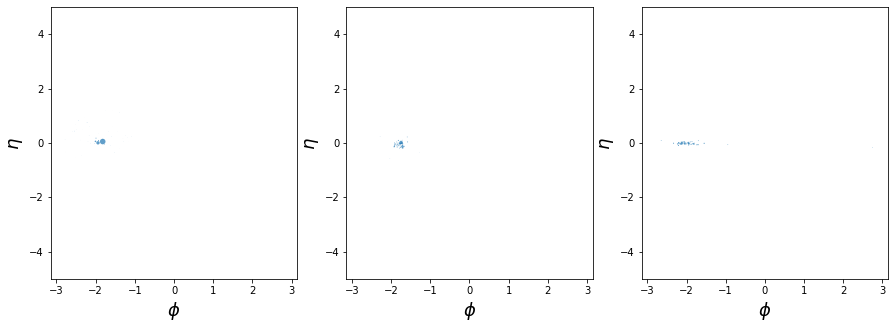

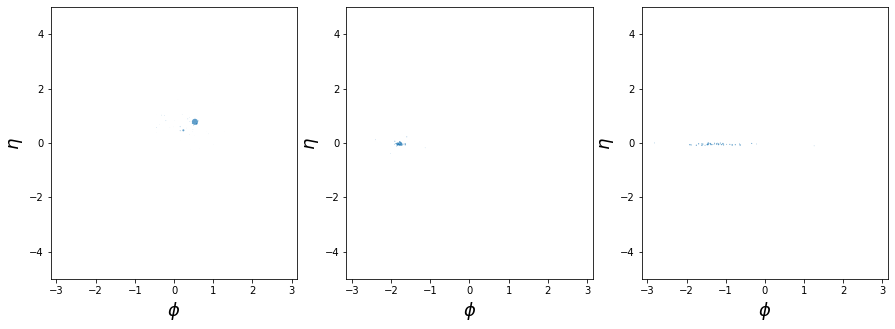

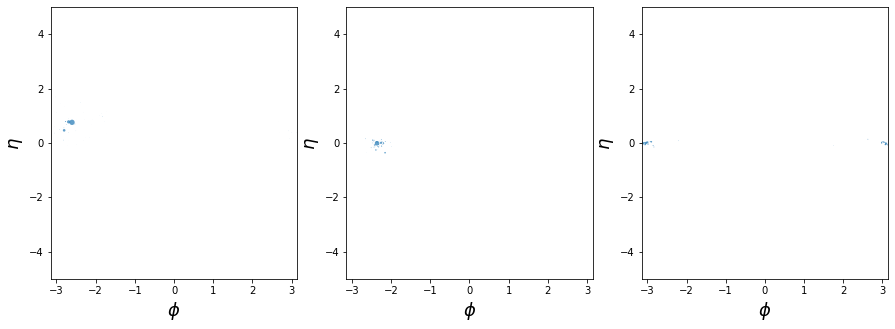

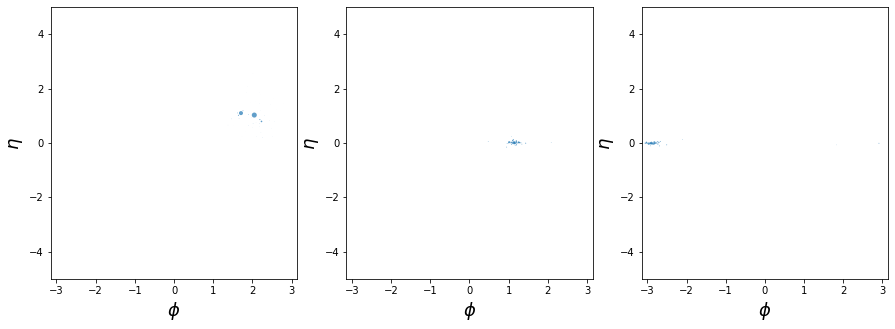

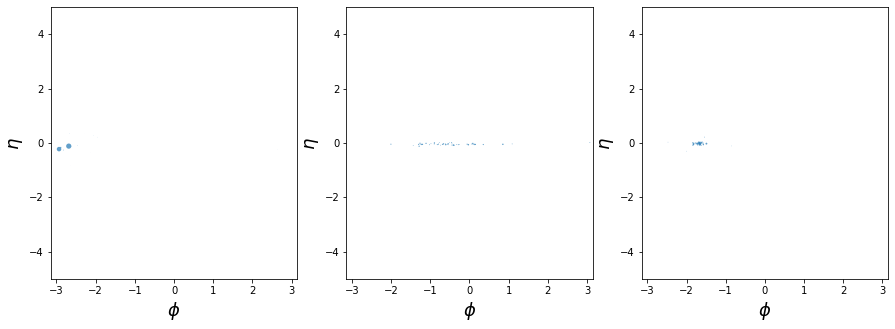

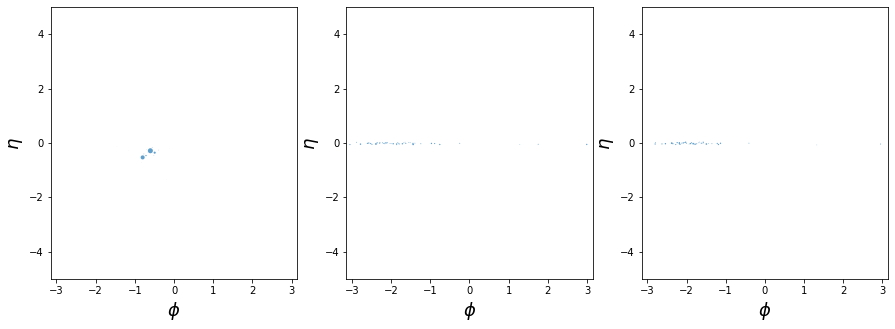

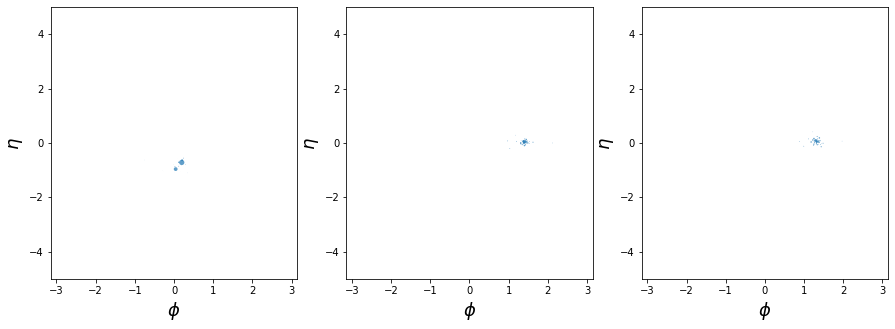

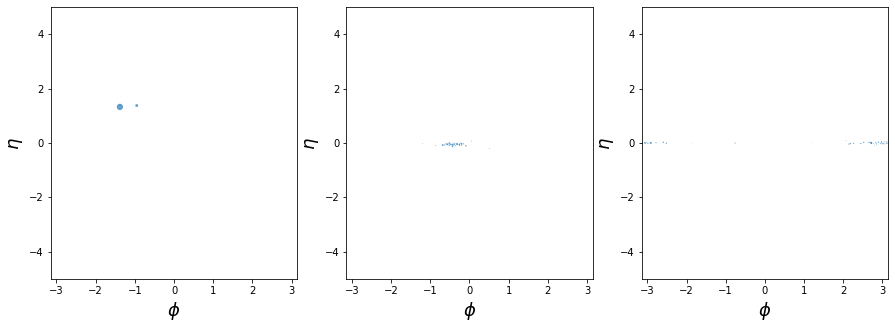

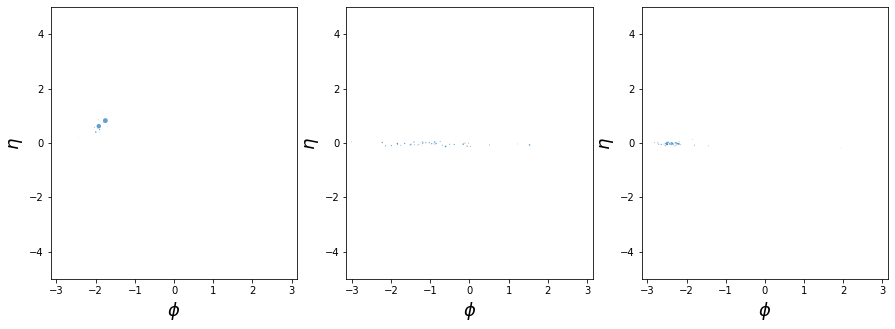

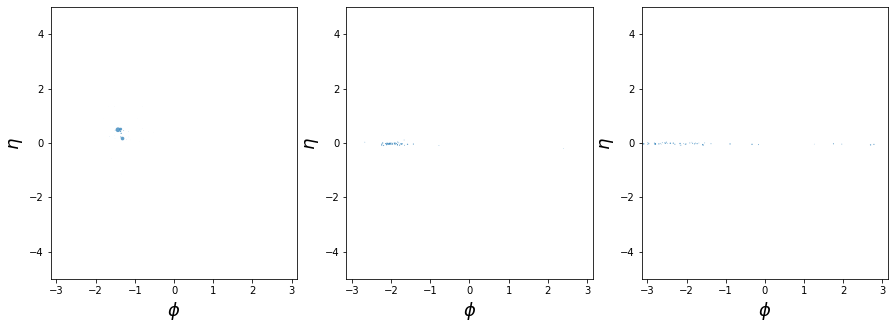

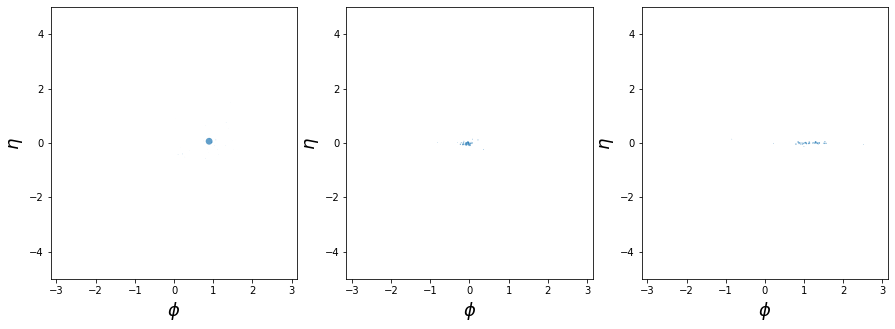

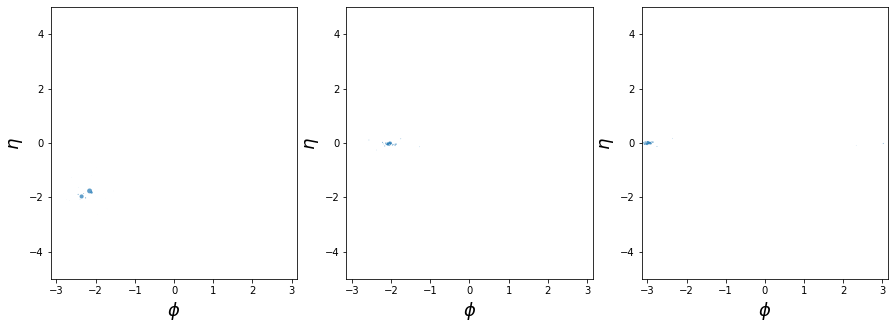

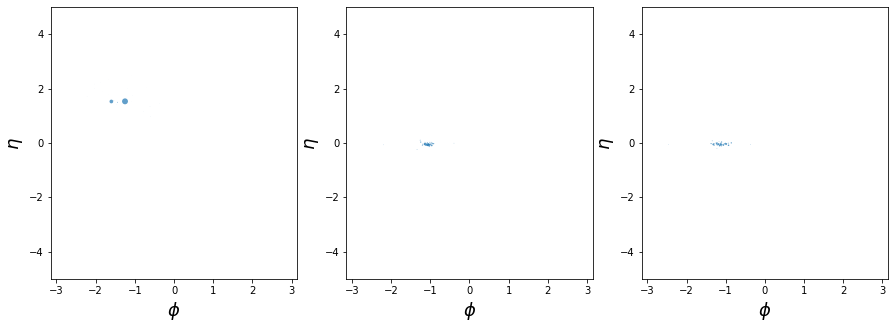

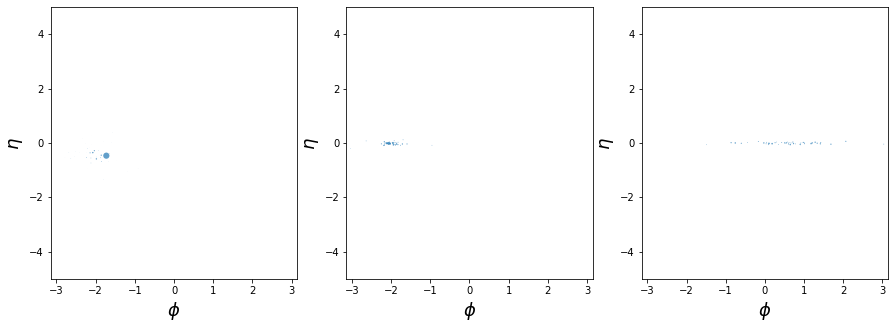

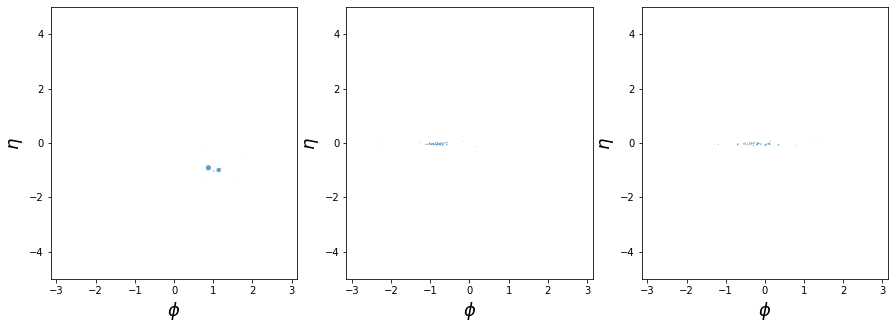

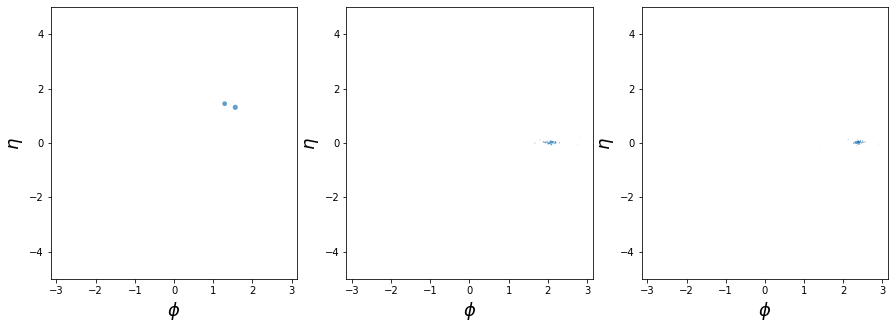

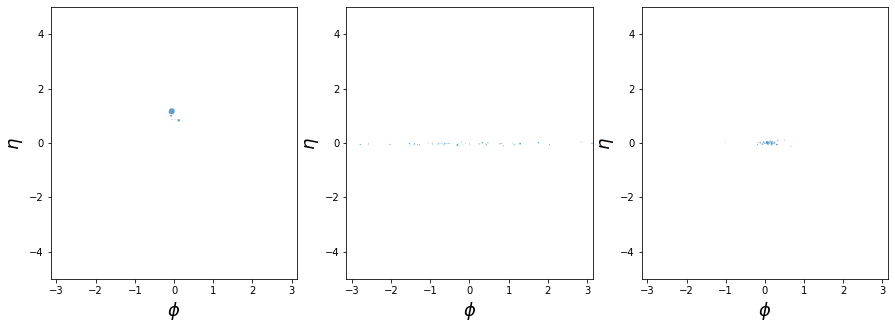

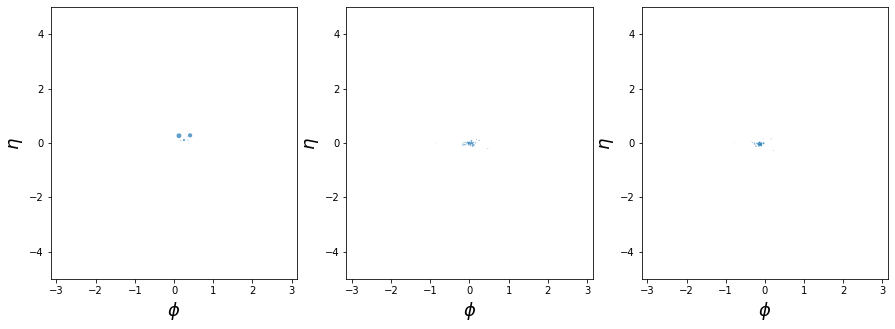

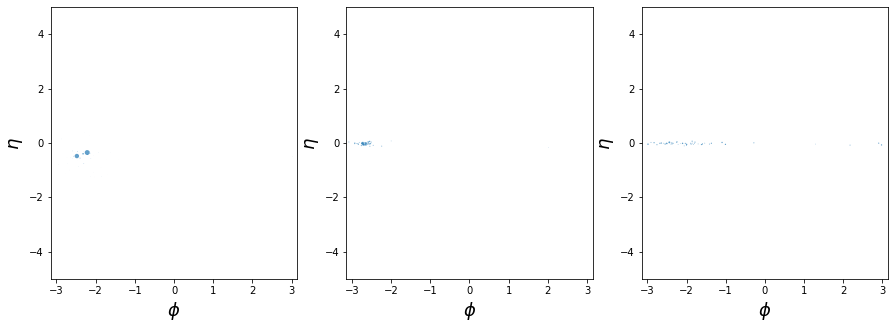

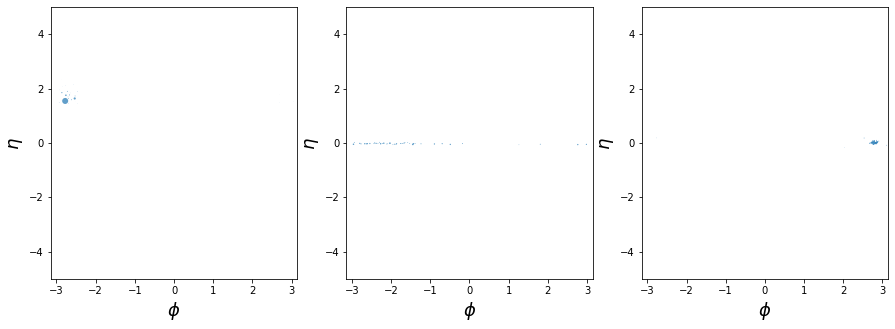

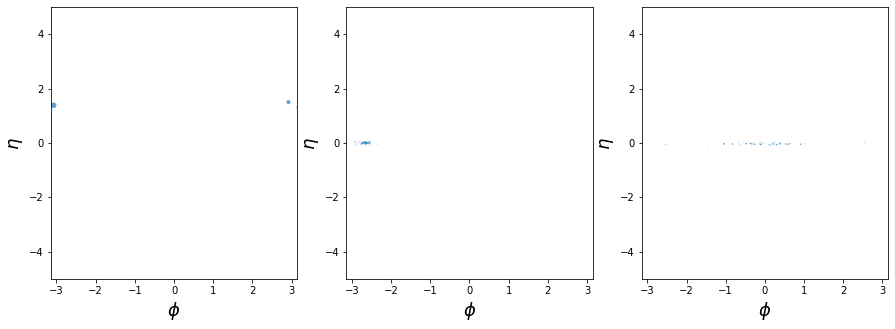

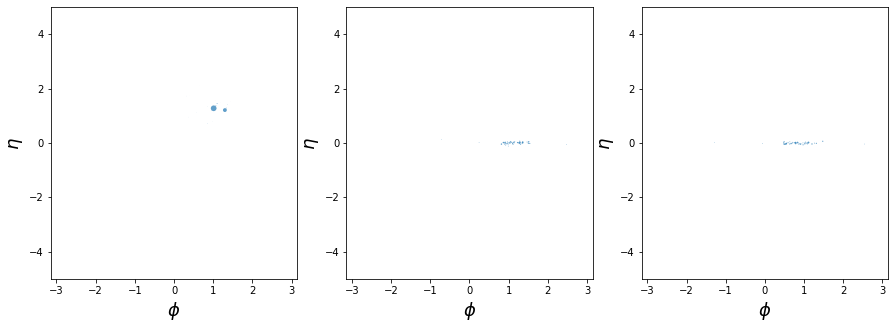

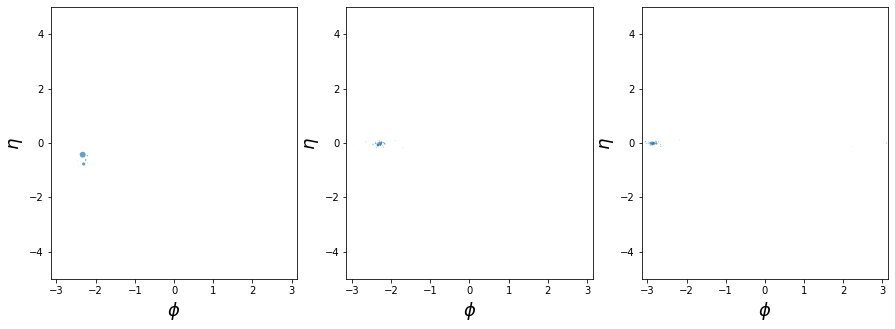

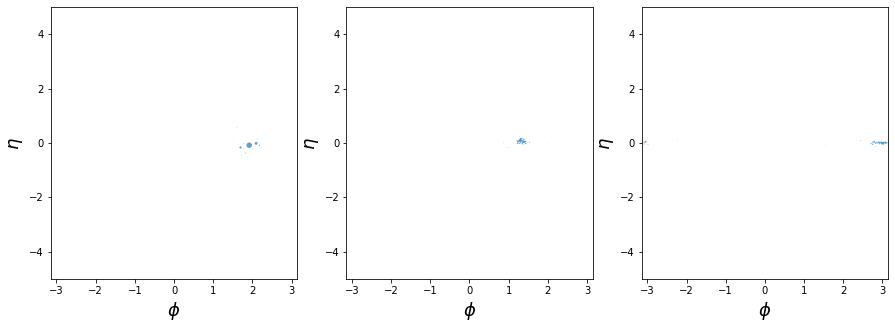

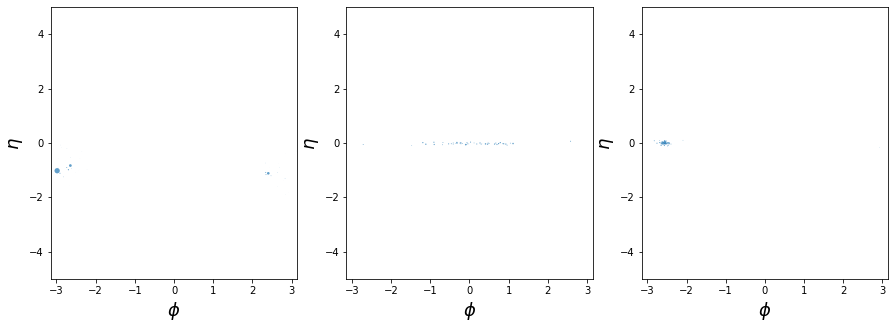

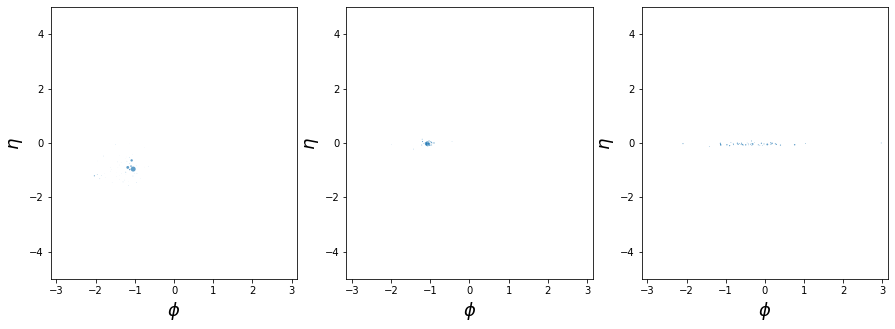

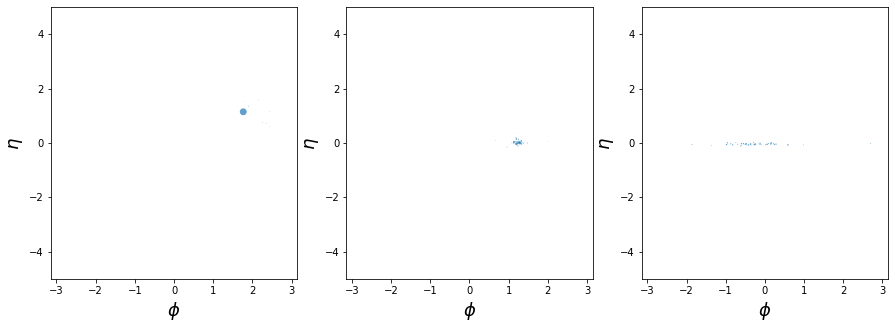

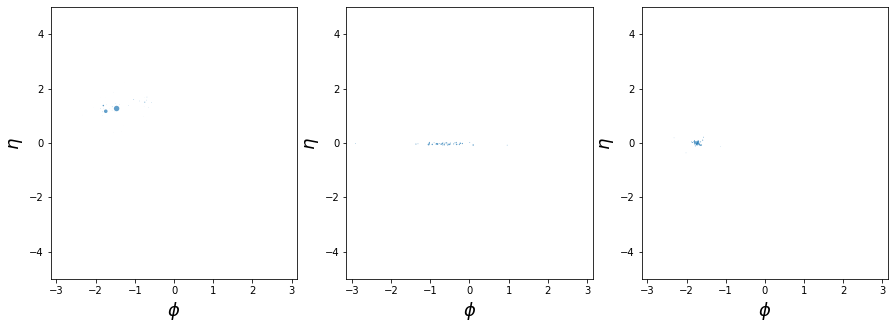

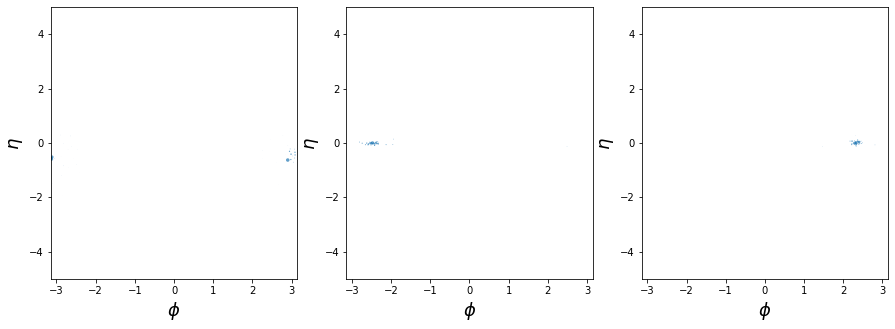

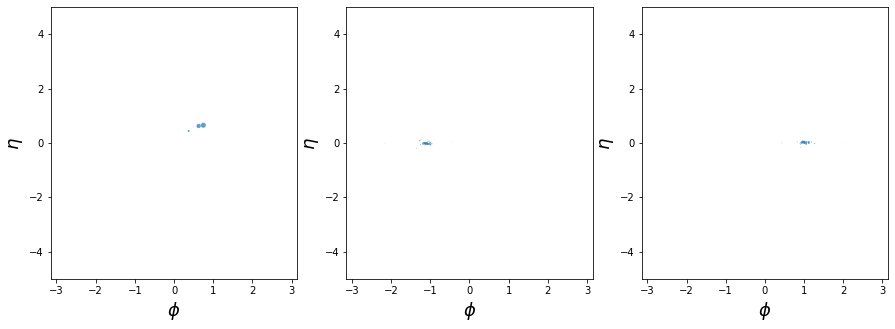

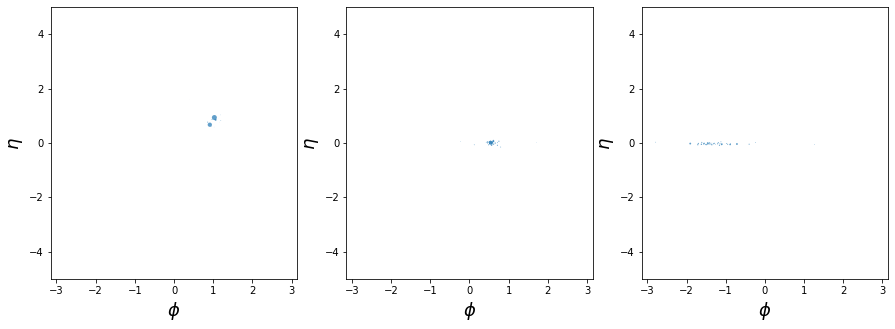

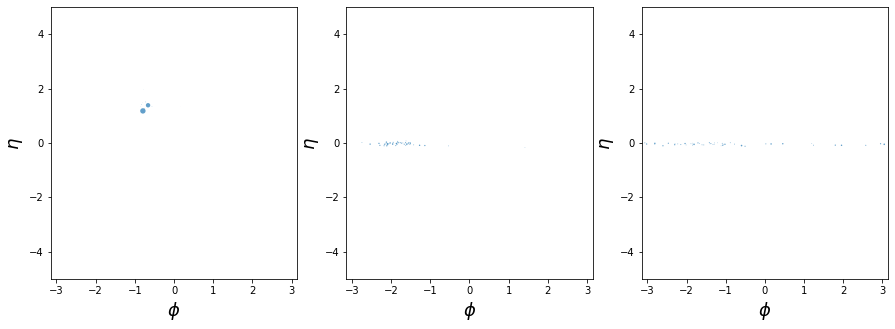

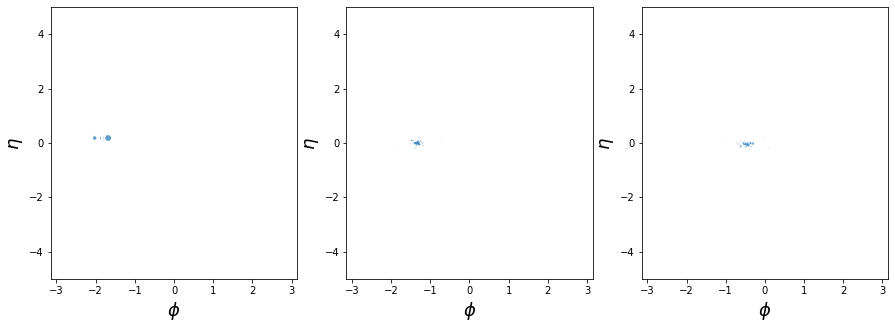

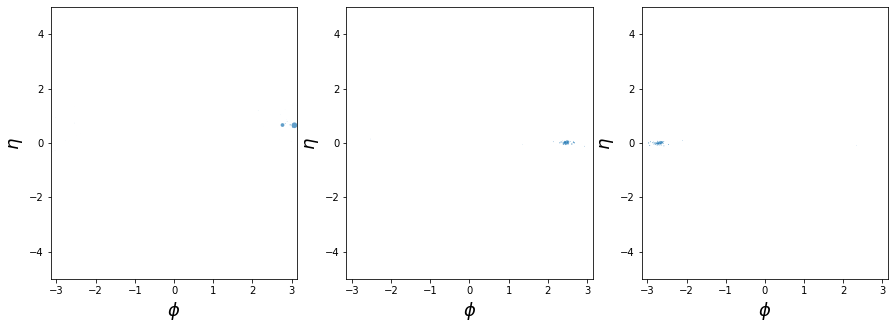

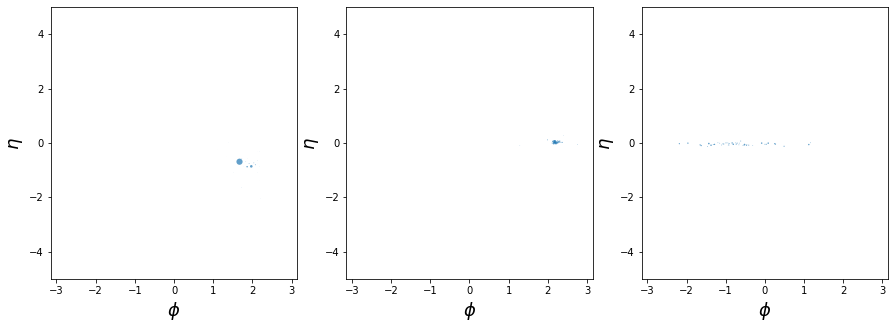

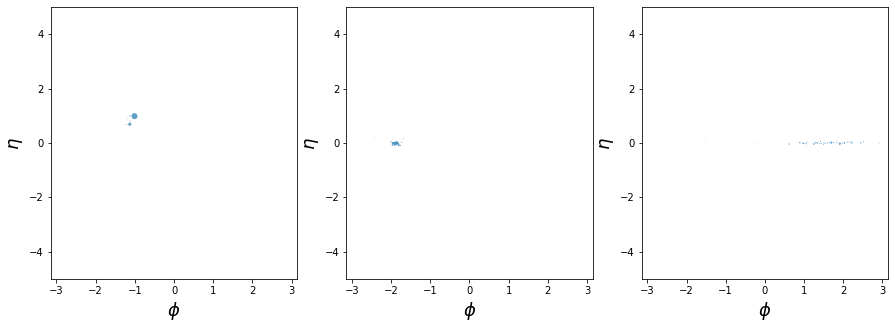

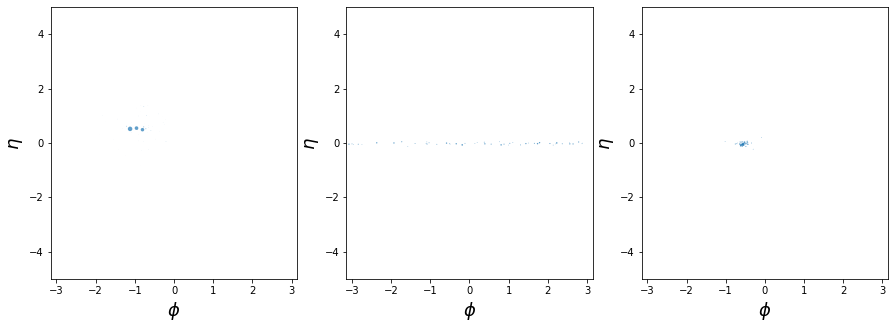

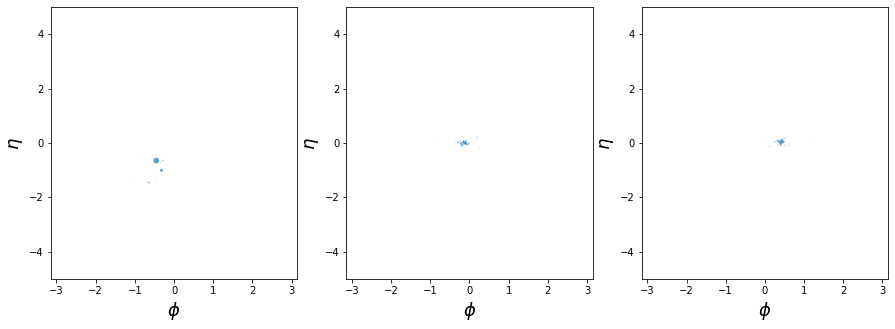

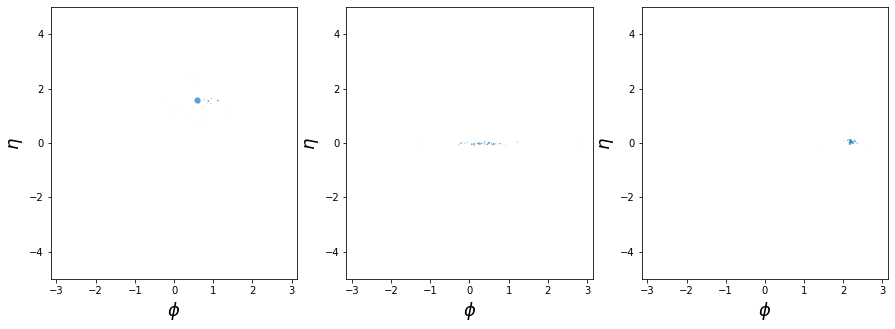

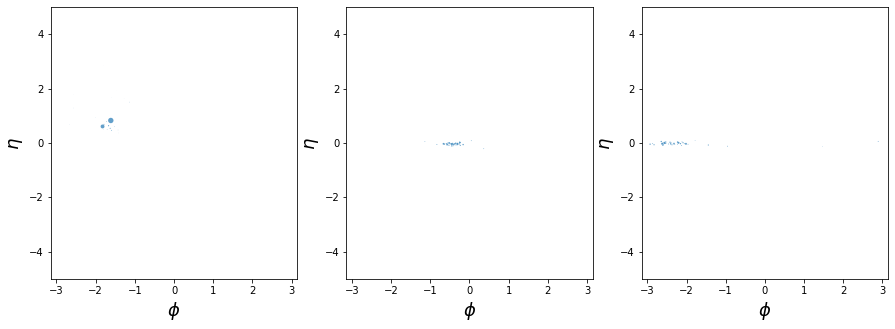

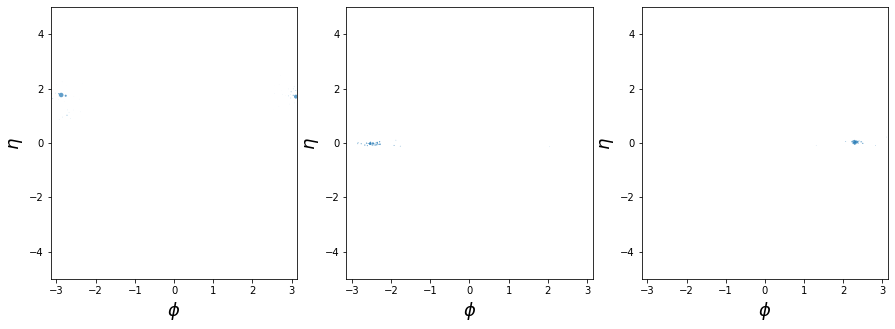

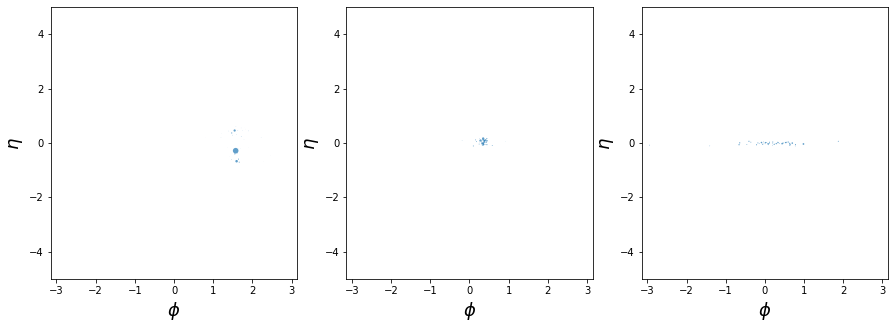

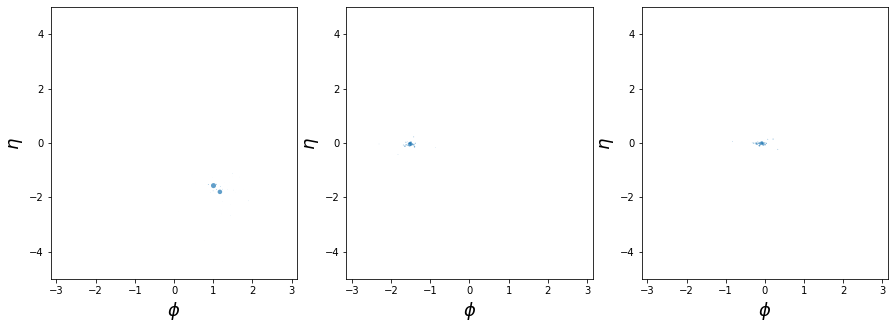

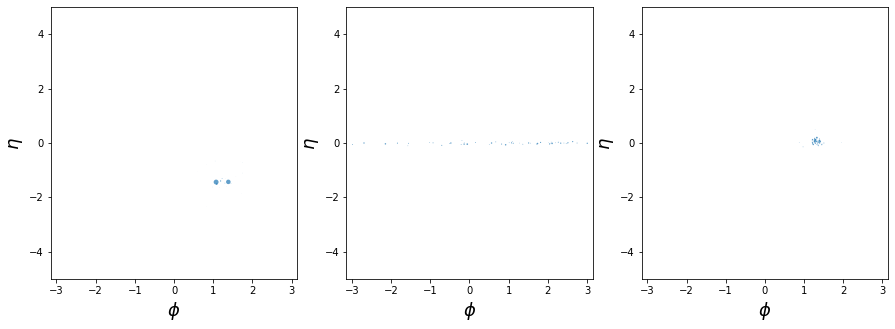

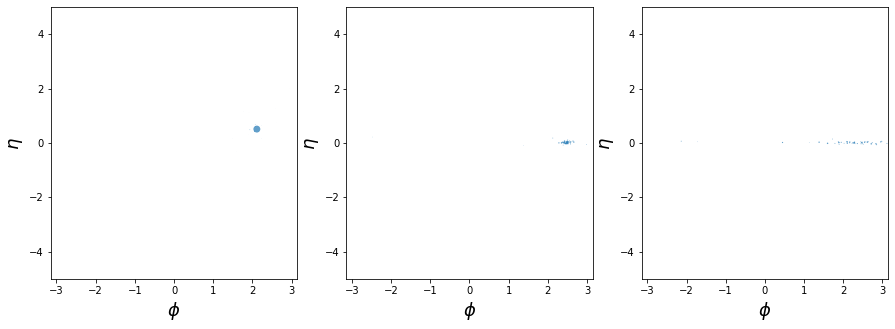

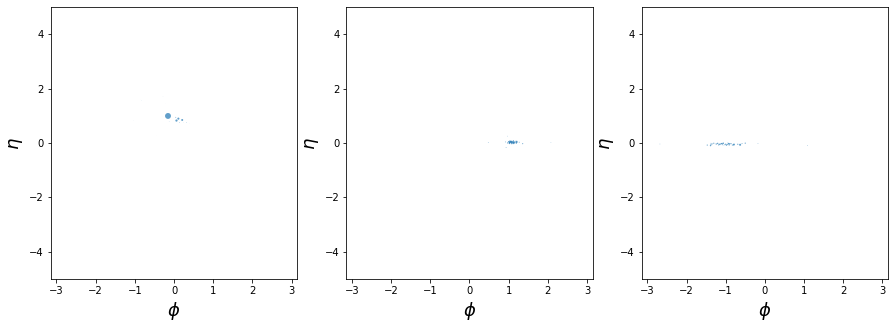

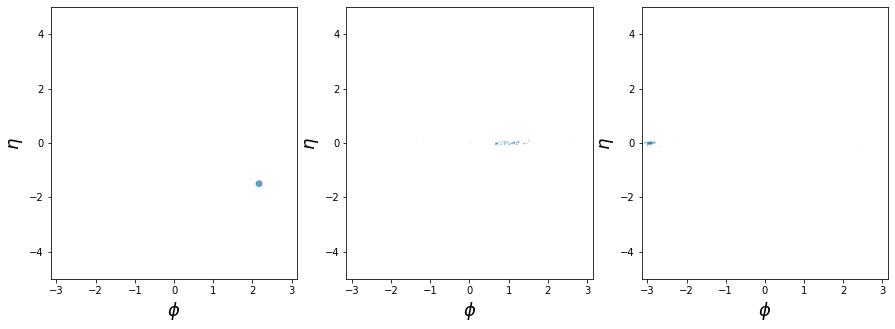

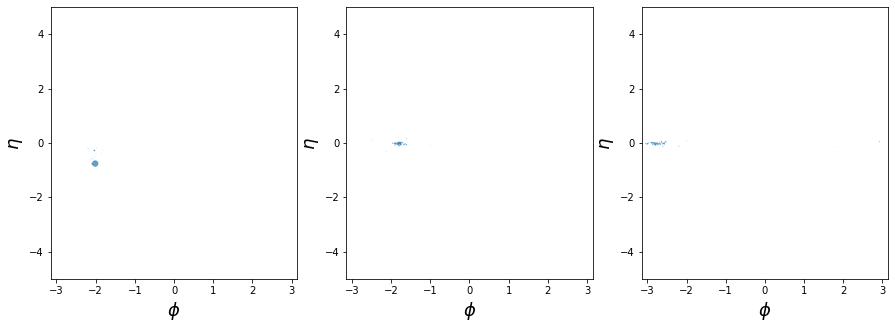

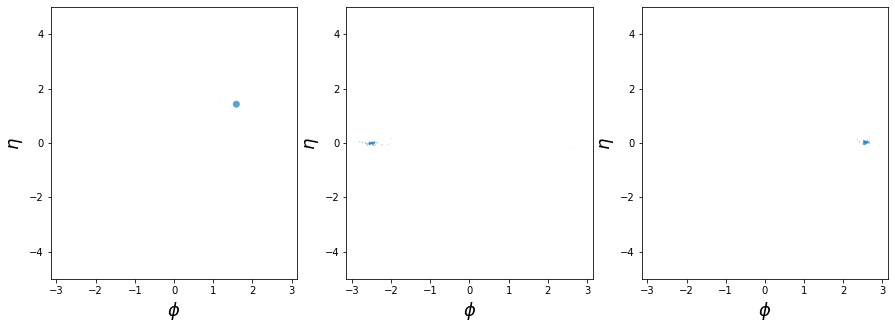

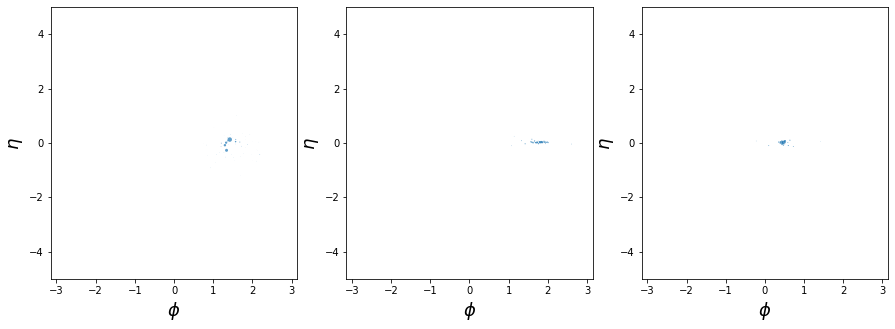

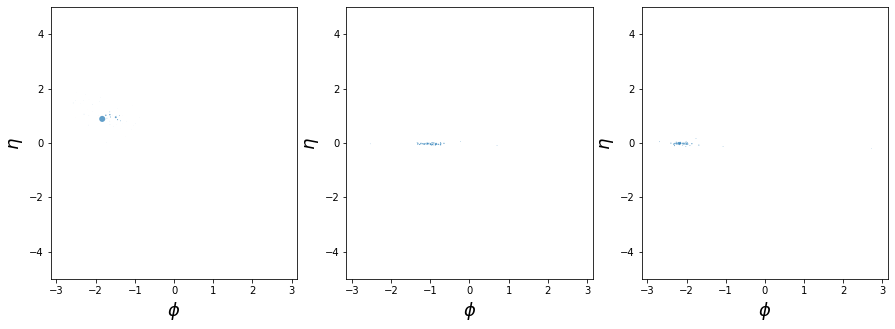

In [44]:
countcut=0.9
etalim=5
#bins=np.linspace(-lim, lim, 126)

for i in range(100):   

    fig, ax = plt.subplots(1, 3,figsize=[15,5])

    

    outjet = valid_y[i,:,1:]
    weights = valid_y[i,:,0]
    pts, etas, phis = get_clustered_pt_eta_phi(weights, outjet,R=0.03)
    ax[0].scatter(phis, etas, s = pts*50, alpha = 0.7,linewidths=0)
    

    #ax[0].hist2d(feed_pc[i][:,0],feed_pc[i][:,1],range=[[-lim,lim],[-lim,lim]],bins=bins, norm=LogNorm(0.5, 1000))
    for j in range(2):
        outjet = outs_array[j][0][i,:,1:]
        weights = outs_array[j][0][i,:,0]
        pred_labels = outs_array[j][-2][i]
        pts, etas, phis = get_clustered_pt_eta_phi(weights, outjet,R=0.02)
        ax[j+1].scatter(phis, etas, s = pts*50, alpha = 0.7,linewidths=0)
#         counts, bx, by = np.histogram2d(np.mod(np.pi+x_outs[j][i,:,0],2*np.pi)-np.pi,x_outs[j][i][:,1],bins=bins,weights=pt_outs[j][i]*100)
#         ax[j+1].imshow(counts.T, norm=LogNorm(countcut,100), origin='lower',cmap='Oranges',extent=[-lim, lim, -lim, lim])
    
    for j in range(3):
        ax[j].set_ylabel(r'$\eta$',fontsize=18)
        ax[j].set_xlabel(r'$\phi$',fontsize=18)
        ax[j].set_ylim([-etalim,etalim])
        ax[j].set_xlim([-np.pi,np.pi])
    
    plt.show()

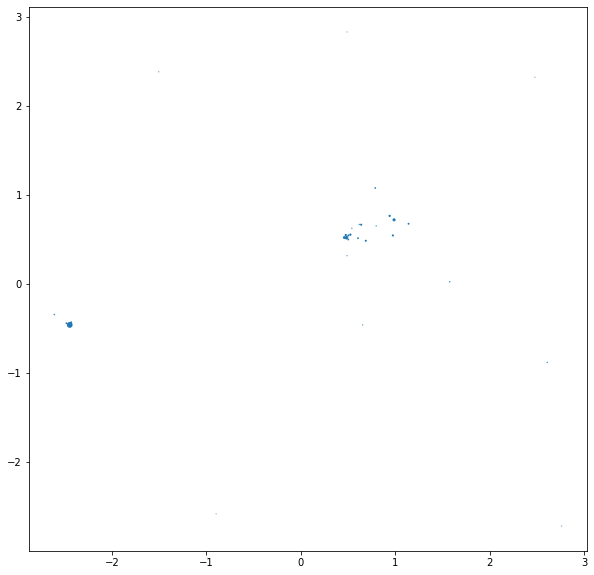

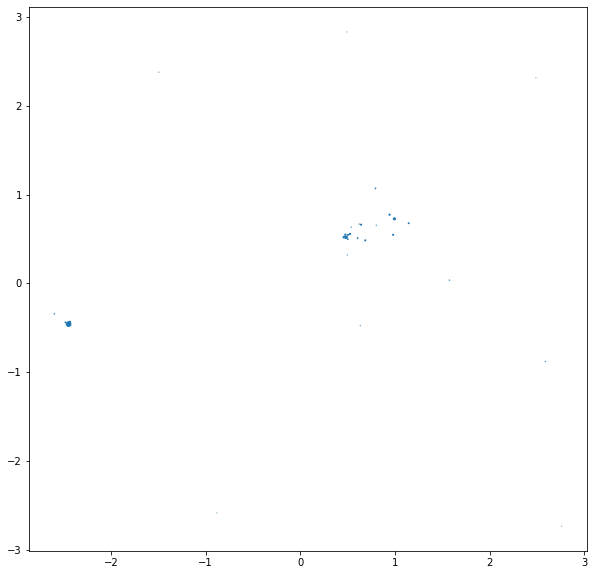

In [101]:

outjet = result[:,1:]
weights = result[:,0]
pts, etas, phis = get_clustered_pt_eta_phi(weights, outjet,R=0.02)
plt.figure(figsize=[10,10])
plt.scatter(phis, etas, s = pts*50, alpha = 1.,linewidths=1)

plt.show()


outjet = result_2[:,1:]
weights = result_2[:,0]
pts, etas, phis = get_clustered_pt_eta_phi(weights, outjet,R=0.02)
plt.figure(figsize=[10,10])
plt.scatter(phis, etas, s = pts*50, alpha = 1.,linewidths=1)

plt.show()


NameError: name 'valid_labels' is not defined

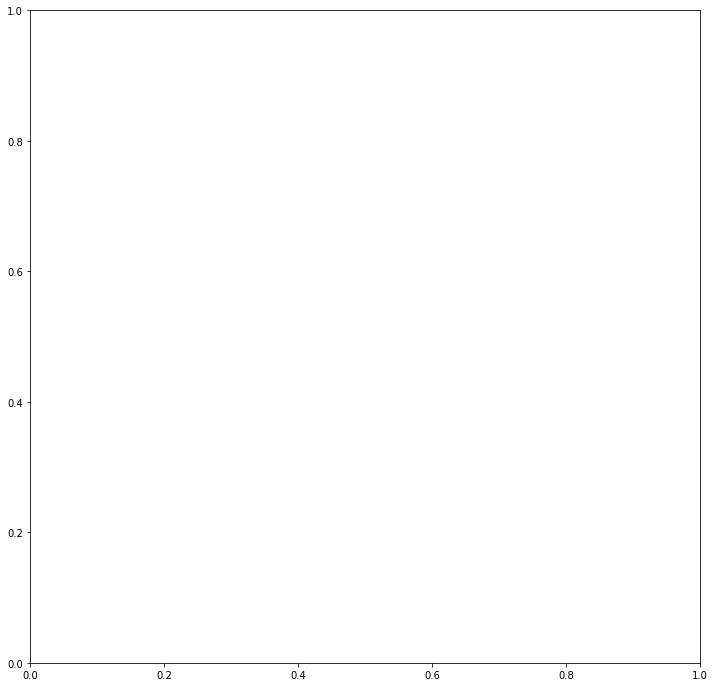

In [17]:
countcut=0.9
etalim=5
#bins=np.linspace(-lim, lim, 126)

for i in range(200):   

    fig, ax = plt.subplots(1, 1,figsize=[12,12])

    print(valid_labels[i], p_bern[i][bernsort_means[:5]])

    outjet = valid_y[i,:,1:]
    weights = valid_y[i,:,0]
    pts, etas, phis = get_clustered_pt_eta_phi(weights, outjet,R=0.02)
    plt.scatter(phis, etas, s = pts*100, alpha = 0.5,linewidths=0)
    

#     #ax[0].hist2d(feed_pc[i][:,0],feed_pc[i][:,1],range=[[-lim,lim],[-lim,lim]],bins=bins, norm=LogNorm(0.5, 1000))
#     for j in range(2):
#         outjet = outs_array[j][0][i,:,1:]
#         weights = outs_array[j][0][i,:,0]
#         pred_labels = outs_array[j][-1][i]
#         print(pred_labels[bernsort_means[:5]])
#         pts, etas, phis = get_clustered_pt_eta_phi(weights, outjet,R=0.02)
#         ax[j+1].scatter(phis, etas, s = pts*40, alpha = 0.5,linewidths=0)
# #         counts, bx, by = np.histogram2d(np.mod(np.pi+x_outs[j][i,:,0],2*np.pi)-np.pi,x_outs[j][i][:,1],bins=bins,weights=pt_outs[j][i]*100)
# #         ax[j+1].imshow(counts.T, norm=LogNorm(countcut,100), origin='lower',cmap='Oranges',extent=[-lim, lim, -lim, lim])
    
    for j in range(1):
        plt.ylabel(r'$\eta$',fontsize=18)
        plt.xlabel(r'$\phi$',fontsize=18)
        plt.ylim([-etalim,etalim])
        plt.xlim([-np.pi,np.pi])
    
    plt.show()

In [277]:
pred_labels[-10]

1.342633e-10

0.0 [3.8742874e-06 3.2316554e-01 4.2153373e-03]
[1.6602369e-18 6.4934880e-02 7.6476899e-06]
[2.7918960e-17 3.6906080e-05 3.0217095e-09]
[2.3916770e-21 1.4188743e-01 1.0886861e-09]


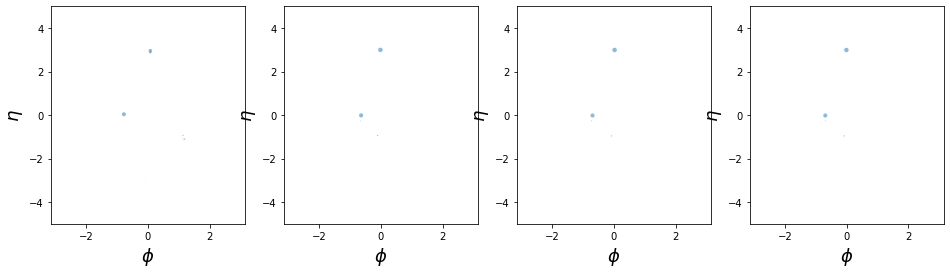

1.0 [1.0728721e-05 1.1278614e-01 1.9440929e-03]
[1.7836355e-18 7.7131093e-03 2.2198333e-11]
[2.0459001e-18 1.0538995e-03 6.1934374e-11]
[2.6785437e-19 7.5096104e-08 3.0465580e-10]


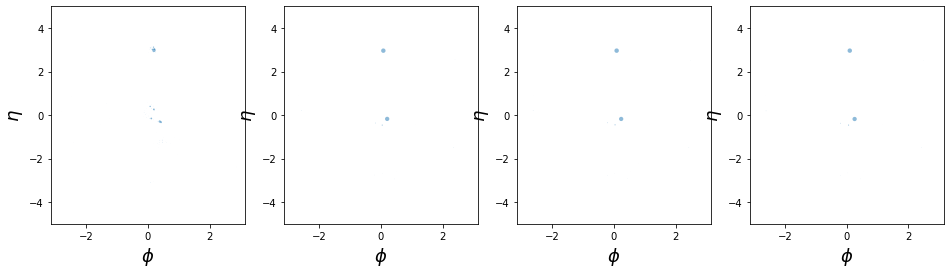

0.0 [1.5318161e-05 2.7105734e-01 1.8837661e-03]
[9.8579901e-19 9.9564850e-01 2.1181695e-13]
[3.5884381e-16 2.6881081e-01 1.0798199e-10]
[3.3717431e-14 1.0307431e-03 1.0360169e-07]


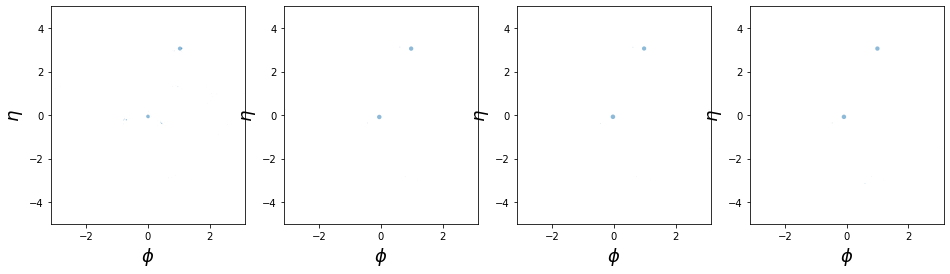

0.0 [1.5735379e-05 3.2226104e-02 1.0631095e-03]
[5.5742497e-17 1.8918514e-04 8.9036471e-14]
[6.2396047e-16 1.1957181e-06 9.6791802e-12]
[3.3296192e-15 1.2142688e-02 4.8109559e-12]


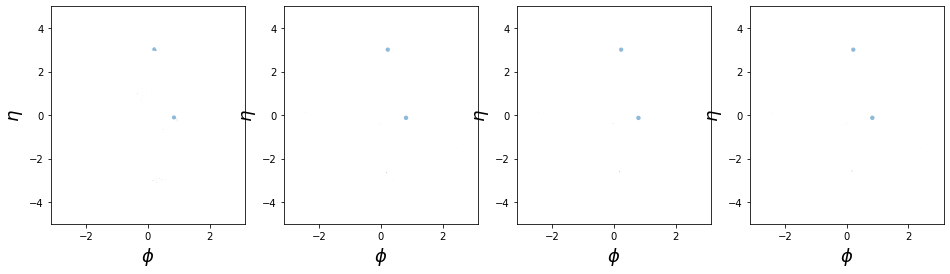

0.0 [1.6569817e-05 4.4501774e-02 8.5411966e-04]
[5.1864870e-16 2.5813588e-05 4.1294350e-11]
[8.2747423e-17 1.3869762e-02 6.5228593e-15]
[6.6731255e-19 4.5542793e-06 3.0020639e-12]


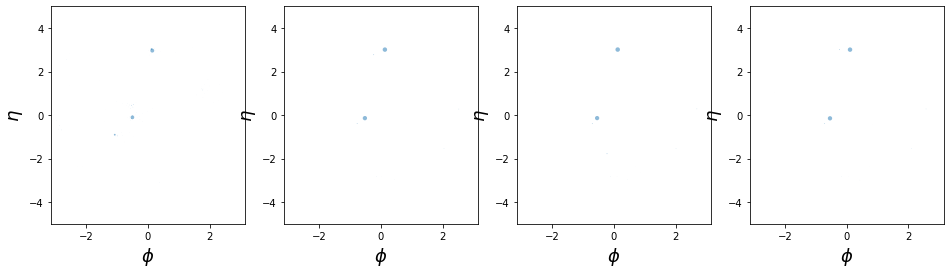

0.0 [1.6748625e-05 2.8225347e-01 1.4146790e-03]
[8.2912904e-19 4.6771193e-01 3.8817136e-09]
[2.4368263e-17 7.8418851e-04 2.3707747e-04]
[1.2495874e-21 4.5921422e-07 2.2150720e-10]


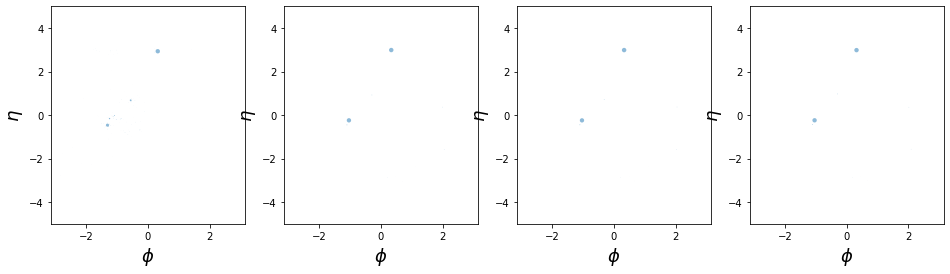

0.0 [1.8417497e-05 1.6487214e-01 1.4314991e-03]
[1.4568797e-15 1.9918978e-03 2.2126958e-09]
[2.6567563e-19 7.8180856e-05 3.3256373e-07]
[9.8944159e-20 8.2102792e-07 1.1419946e-11]


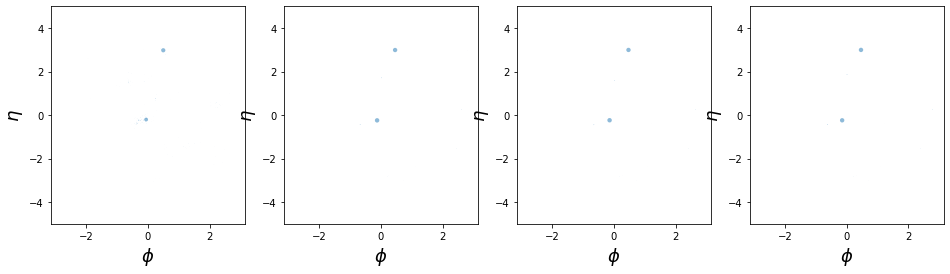

0.0 [2.2947263e-05 5.5399281e-01 4.3376656e-03]
[1.0289342e-13 9.9962711e-01 6.4411029e-07]
[2.7308980e-16 4.3686836e-09 2.2014078e-07]
[5.4015326e-13 5.6360960e-03 9.5467556e-10]


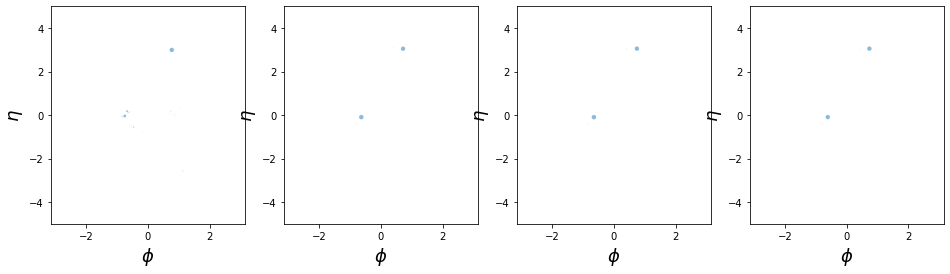

0.0 [2.8013399e-05 4.8294690e-02 1.8933264e-03]
[8.149030e-14 1.664295e-05 4.811069e-05]
[2.218048e-14 6.414652e-04 1.772475e-10]
[1.28817169e-14 1.10003352e-03 1.04048704e-04]


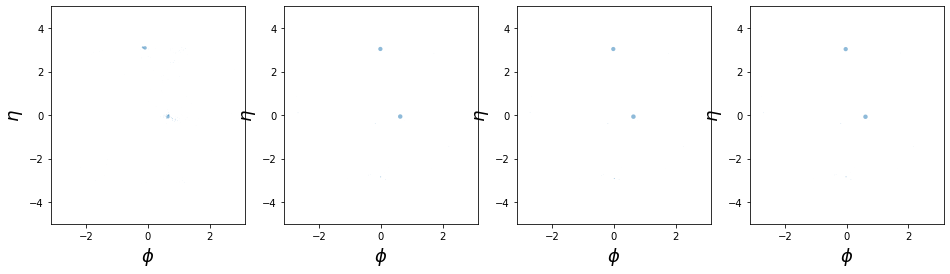

0.0 [2.8311402e-05 6.2989444e-01 1.5313073e-02]
[3.4048770e-14 2.4235785e-02 9.8558778e-01]
[1.2599596e-14 3.5373509e-02 1.6271601e-06]
[2.0585218e-16 5.8453369e-01 3.1196009e-07]


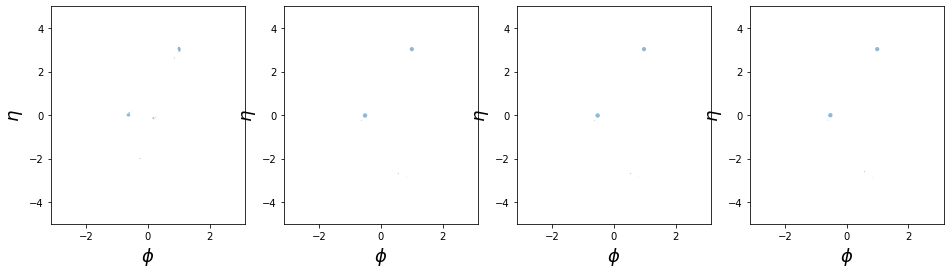

0.0 [3.0337846e-05 6.1179880e-02 3.8695820e-03]
[8.4594456e-09 2.0551879e-06 1.7329562e-09]
[1.29218122e-07 2.94300616e-01 1.15730345e-05]
[1.78219268e-19 2.27745568e-06 1.14481786e-07]


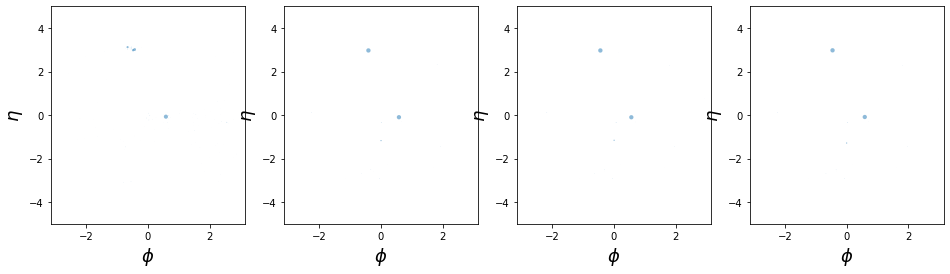

0.0 [3.5940306e-05 3.9669994e-01 1.2082505e-02]
[6.6300255e-16 3.5241159e-05 4.2955881e-07]
[6.9389030e-18 2.5240824e-01 2.3797764e-07]
[2.5712891e-17 9.9779814e-01 1.1799634e-03]


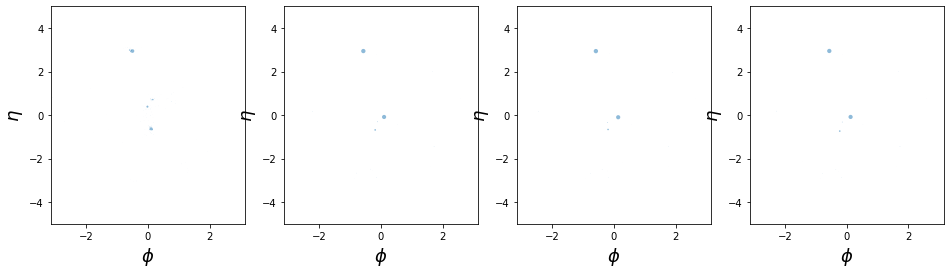

0.0 [3.647671e-05 7.035216e-02 3.065636e-03]
[6.2678473e-17 4.5839380e-07 1.5282631e-04]
[2.8137316e-15 1.2160540e-03 6.0778383e-08]
[3.3510503e-16 1.8439922e-01 3.3205476e-09]


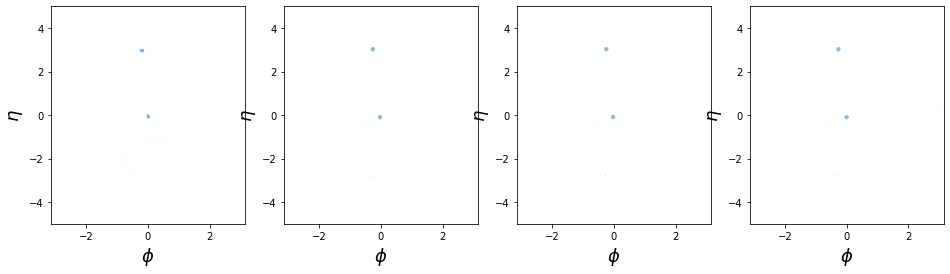

0.0 [4.1781113e-05 3.6830017e-01 4.9109091e-03]
[9.9607321e-19 6.7760473e-01 2.8521061e-11]
[6.9394695e-15 7.6252043e-02 2.8115860e-11]
[2.6232478e-14 4.3535829e-03 3.7409663e-03]


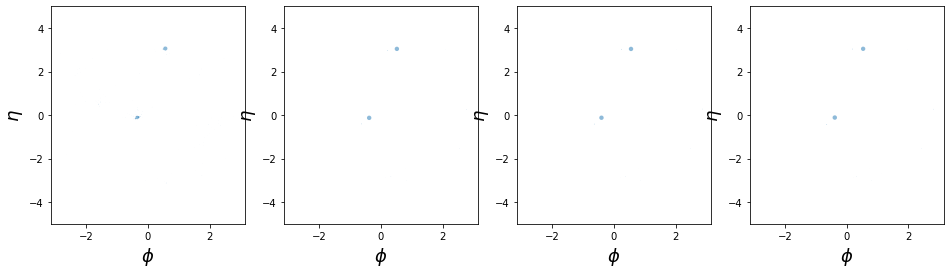

0.0 [4.4522683e-05 6.7905672e-02 1.6921093e-03]
[1.3256967e-12 7.6220436e-14 6.4769679e-10]
[9.319932e-14 9.498745e-03 5.582489e-08]
[4.7832138e-12 6.1007563e-07 3.8813987e-11]


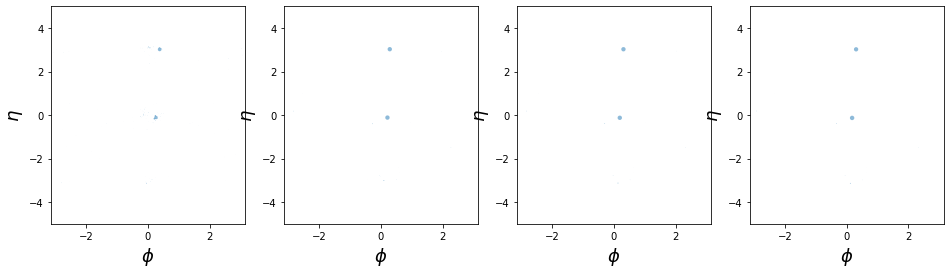

0.0 [5.5071658e-05 2.5678152e-01 3.7410446e-03]
[4.1048394e-15 2.7023846e-01 6.2084884e-09]
[3.3143491e-15 1.9109462e-05 3.3749153e-10]
[9.0335443e-19 4.1914582e-03 5.8180163e-08]


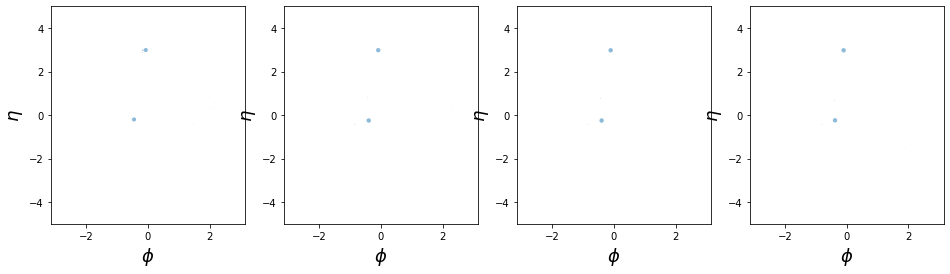

0.0 [6.4905253e-05 3.3120158e-01 1.2673711e-02]
[1.6942487e-14 1.2779236e-04 2.2914335e-08]
[8.8047264e-16 3.6616772e-01 5.5720244e-07]
[1.8420737e-10 9.9999976e-01 2.2062618e-06]


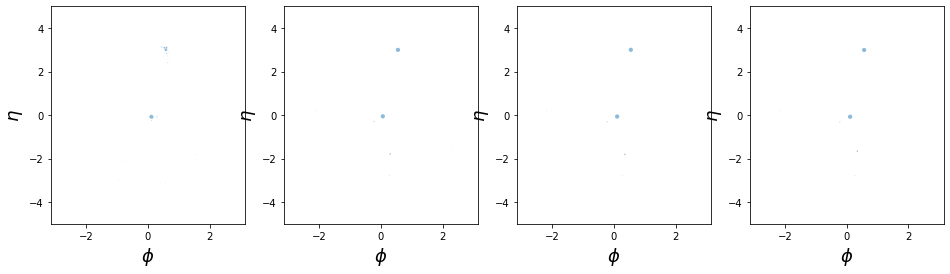

0.0 [6.5382024e-05 1.7153960e-01 6.1471527e-03]
[1.6388794e-19 5.9019923e-03 2.7448142e-09]
[6.9272768e-15 1.0737181e-03 6.6612569e-07]
[2.1135354e-14 4.4276793e-10 5.7448545e-07]


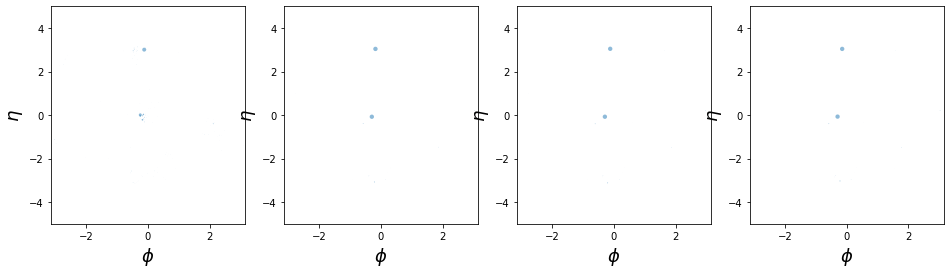

0.0 [6.8242662e-05 2.3631905e-01 1.0540087e-02]
[7.4340058e-16 1.5668005e-02 1.0007420e-06]
[4.5675662e-14 6.9966376e-02 4.2209029e-04]
[6.5257591e-11 8.2441449e-01 1.7696284e-07]


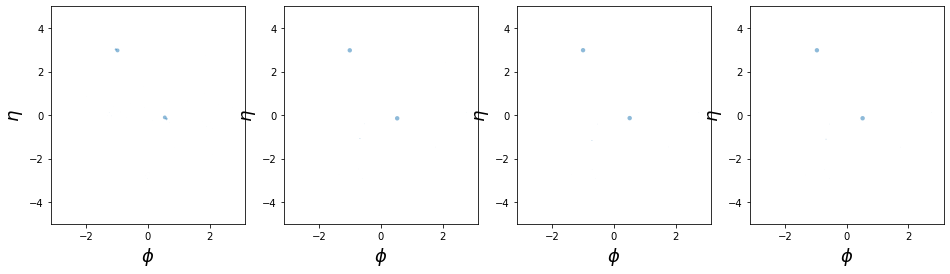

0.0 [6.8779031e-05 2.3915371e-01 6.6859117e-03]
[6.3744074e-15 4.9853712e-02 2.1158601e-07]
[2.8444796e-14 3.0133128e-04 2.8600256e-08]
[6.246741e-11 9.803823e-01 9.930241e-13]


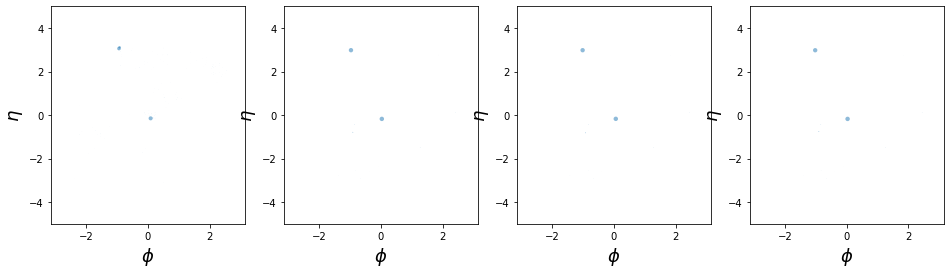

0.0 [7.4738637e-05 1.9270709e-01 1.0033075e-02]
[2.3479774e-14 9.9563110e-01 8.8053122e-07]
[2.5957809e-16 2.5832653e-04 1.2366297e-06]
[1.669898e-14 5.925600e-01 7.102807e-06]


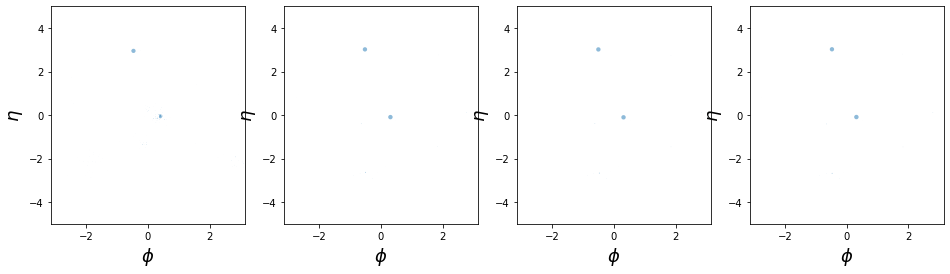

0.0 [7.6526507e-05 5.0530296e-02 3.6276227e-03]
[5.6948814e-13 1.7560528e-11 2.0174232e-10]
[6.5197494e-15 4.2533875e-04 4.5291642e-07]
[9.2596601e-20 5.6099185e-07 9.1708273e-07]


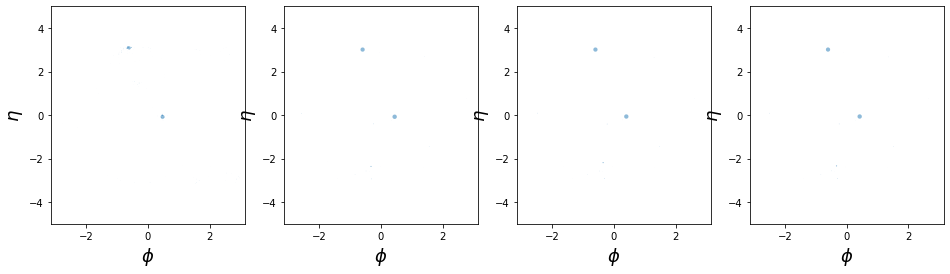

1.0 [7.95062733e-05 1.66056752e-01 1.18299695e-02]
[1.1442842e-18 1.5873671e-02 9.0846015e-08]
[1.9647915e-08 6.9858625e-06 4.3324694e-06]
[1.5491967e-15 5.9247911e-03 1.7563385e-01]


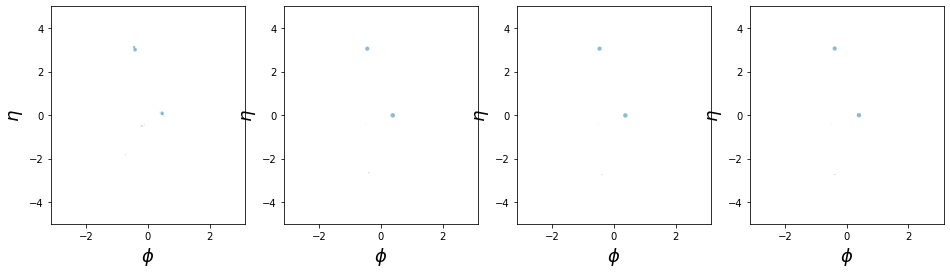

1.0 [8.2366831e-05 1.5227616e-01 8.6731268e-03]
[3.1372444e-15 1.2227297e-03 1.4460190e-06]
[1.1173253e-10 1.0812333e-07 1.2008711e-17]
[2.6265597e-16 2.3308427e-05 6.1573711e-11]


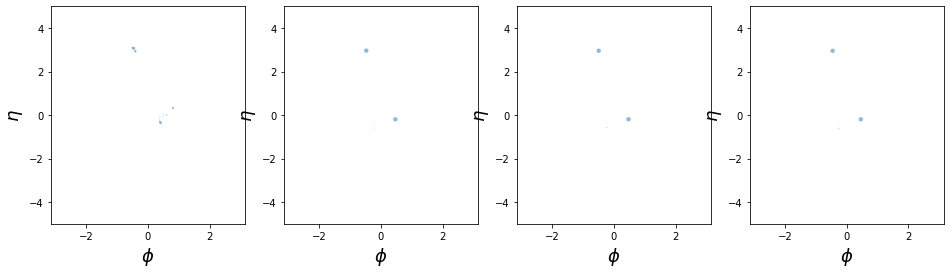

0.0 [8.7372777e-05 2.5933027e-01 8.5008265e-03]
[6.7649739e-15 9.1706502e-01 8.2695484e-04]
[2.2949323e-12 9.8868978e-01 5.0993707e-09]
[1.4792989e-13 8.8879853e-02 1.4605263e-07]


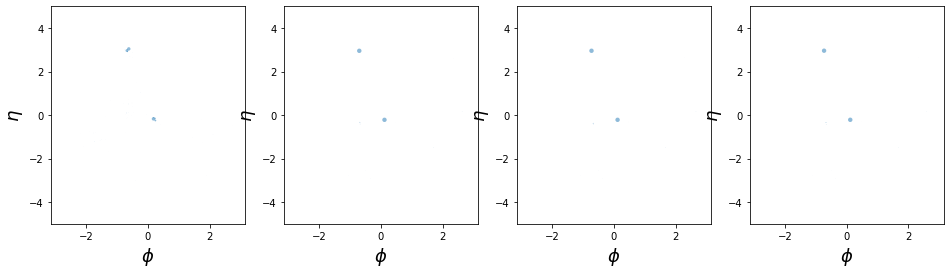

0.0 [8.737278e-05 8.579928e-02 5.117911e-03]
[1.56203619e-10 1.02066905e-11 1.26462812e-10]
[1.852518e-13 4.240811e-03 2.687887e-07]
[4.5843787e-13 1.2194743e-05 5.8220428e-09]


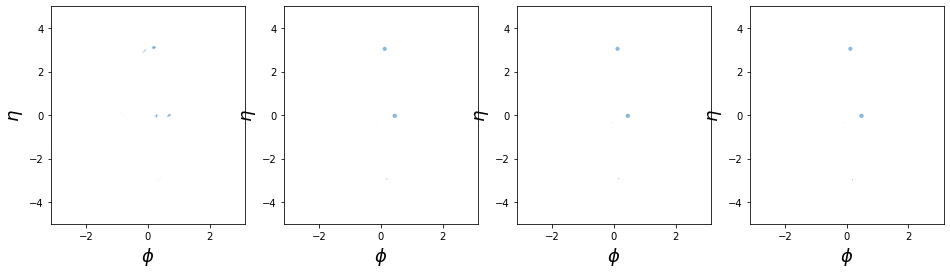

0.0 [8.8087902e-05 2.8517342e-01 1.2281184e-02]
[5.3739150e-15 9.6364164e-01 6.1687359e-08]
[1.6346729e-13 8.9634514e-01 1.9759027e-06]
[6.3918082e-14 9.9893820e-01 1.2623531e-10]


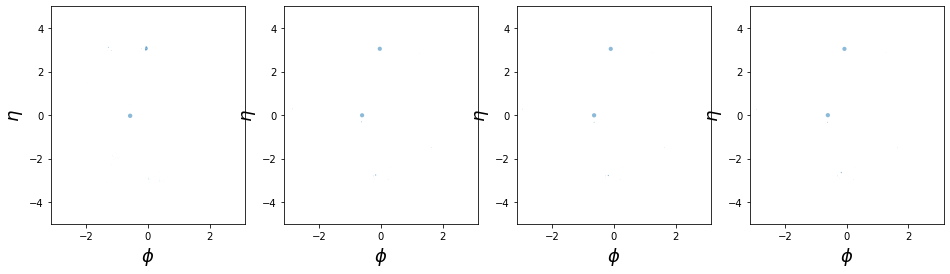

0.0 [1.0131763e-04 7.7718705e-01 3.4297675e-02]
[2.9465225e-11 9.9579036e-01 5.0630188e-05]
[8.5197458e-13 9.9999714e-01 1.8878877e-03]
[6.1591028e-17 9.9989676e-01 5.2459145e-06]


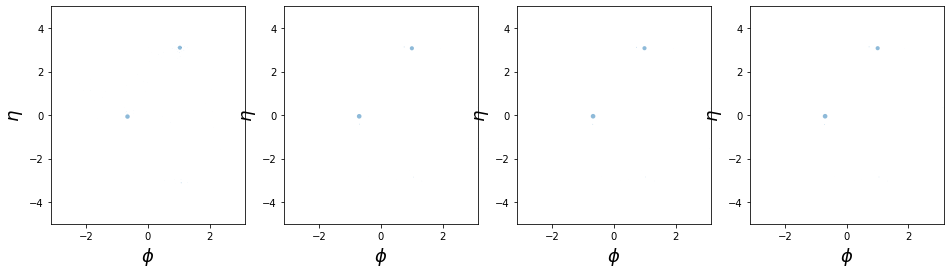

0.0 [1.0179437e-04 3.9123449e-01 7.2088712e-03]
[3.9114004e-15 4.9621165e-03 1.7345228e-10]
[1.3517484e-12 1.6947776e-02 6.0792008e-06]
[5.2682208e-13 1.7343581e-02 5.0081472e-09]


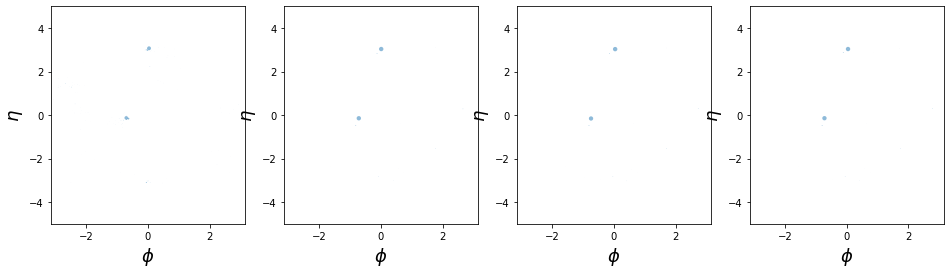

0.0 [1.0924339e-04 4.2040214e-01 1.2008678e-02]
[4.4708994e-14 5.9136355e-01 5.8819172e-08]
[2.7529788e-12 1.8785298e-02 3.2571859e-09]
[3.7988368e-13 2.3952603e-01 4.9147321e-08]


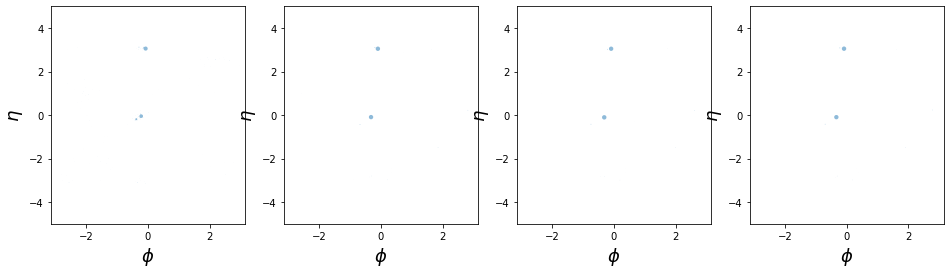

0.0 [1.1567924e-04 6.2078941e-01 2.5117500e-02]
[8.6562653e-11 4.7292417e-01 1.7712637e-06]
[3.3476899e-16 1.2253061e-01 1.5197694e-03]
[3.3357293e-18 9.9671459e-01 3.3673376e-02]


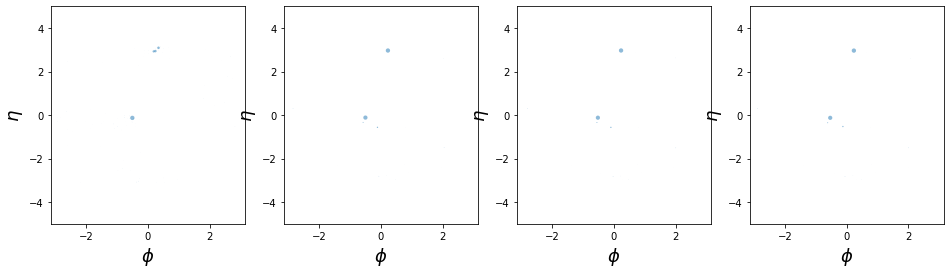

0.0 [1.3510547e-04 6.8222725e-01 2.6717102e-02]
[2.9173535e-11 9.9974871e-01 1.4655087e-05]
[7.058453e-18 6.906488e-01 2.121363e-06]
[4.9758155e-19 9.9998146e-01 7.1477018e-08]


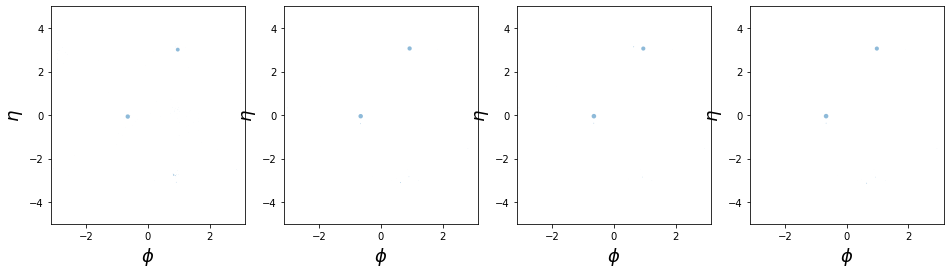

0.0 [1.690102e-04 6.856749e-01 3.124572e-02]
[2.5133828e-10 5.6662793e-05 1.0082284e-06]
[5.3116571e-13 1.1077812e-01 3.9049235e-05]
[4.079440e-12 9.418011e-03 3.034267e-08]


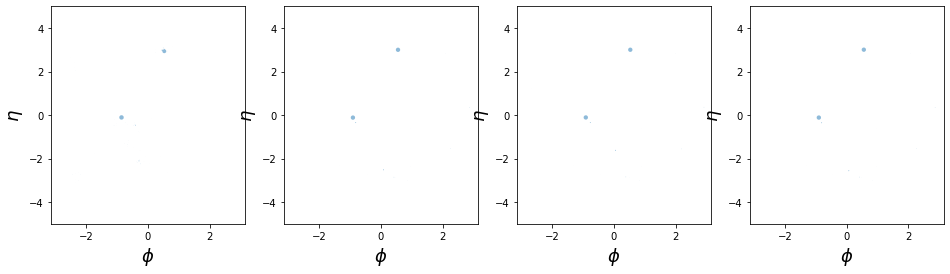

0.0 [0.00018283 0.1545524  0.01396784]
[2.05123418e-10 1.38141195e-05 5.36245359e-09]
[4.9372620e-12 1.7279506e-02 1.2913695e-05]
[3.3030653e-15 7.5131357e-03 3.1601508e-07]


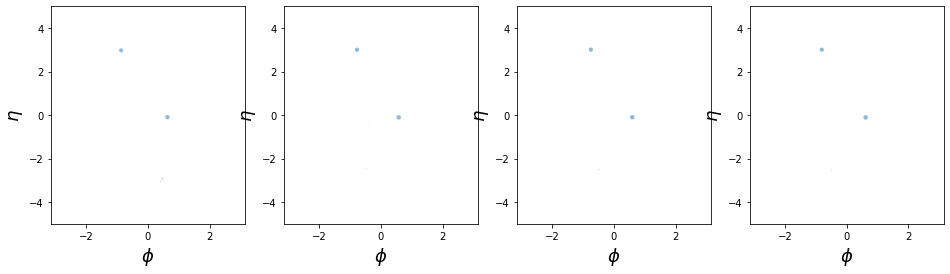

0.0 [1.9105598e-04 1.9828752e-01 1.2445661e-02]
[1.1754156e-10 9.8637307e-01 7.2312355e-04]
[2.40990387e-12 2.85300612e-03 1.03930274e-10]
[5.6411362e-11 9.3182415e-02 8.0159013e-10]


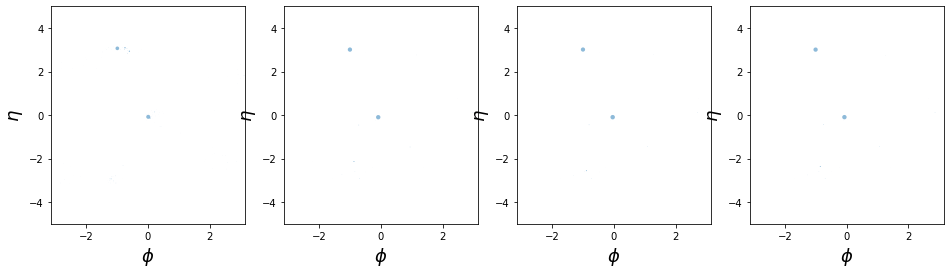

0.0 [2.1661594e-04 6.5418857e-01 3.1479765e-02]
[1.9884398e-13 2.2414327e-04 1.5621607e-07]
[5.6059094e-12 9.9990296e-01 1.1451405e-01]
[6.0517895e-15 9.9827409e-01 8.4668666e-02]


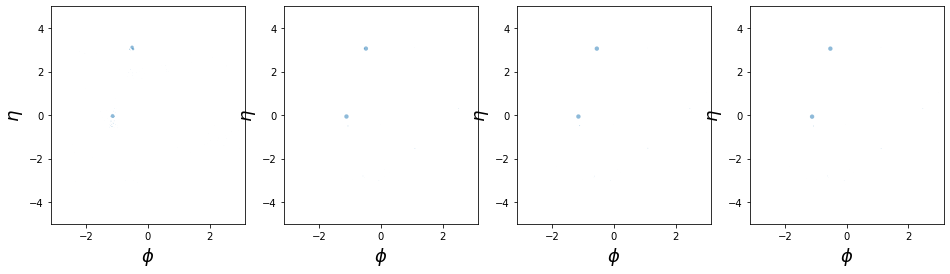

0.0 [2.4473635e-04 5.4150558e-01 1.5735069e-02]
[4.1003596e-13 2.1876752e-02 2.1340424e-01]
[2.2646885e-13 9.9723148e-01 2.5112457e-10]
[2.1192431e-04 2.8474809e-05 8.2200256e-07]


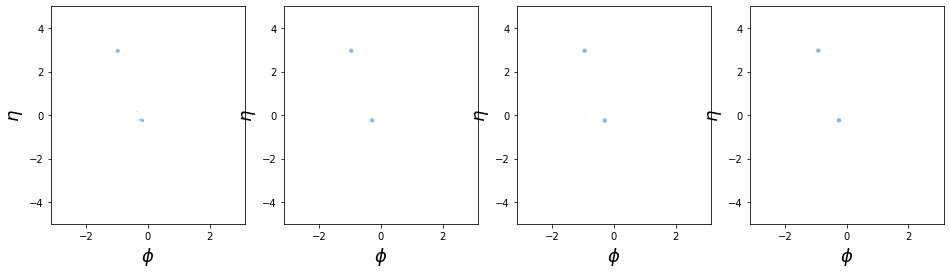

0.0 [2.5432793e-04 7.8934556e-01 8.0991149e-02]
[6.4184262e-11 5.1160305e-07 2.4205028e-07]
[6.9374948e-12 1.0919869e-03 8.4298063e-06]
[7.0805002e-14 2.5631664e-07 6.1261654e-04]


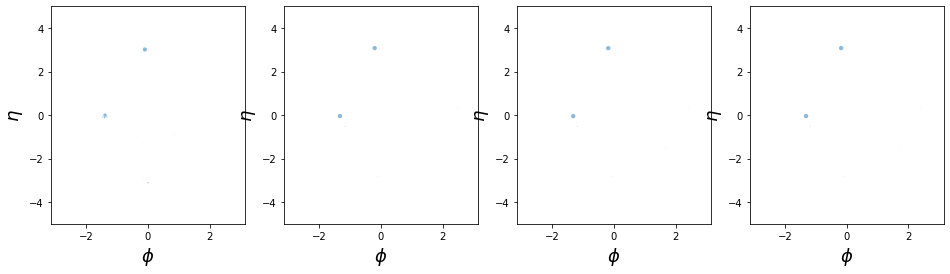

0.0 [2.9864925e-04 8.4623283e-01 1.9126189e-01]
[1.634517e-13 9.997041e-01 8.406913e-02]
[2.1322775e-15 9.9542379e-01 2.6990201e-05]
[2.4732334e-09 9.9342692e-01 3.7053525e-03]


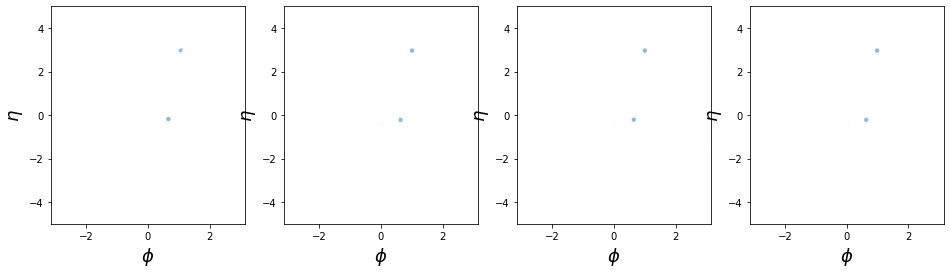

0.0 [3.2301244e-04 7.0647120e-01 5.8429122e-02]
[2.8708244e-16 1.7599493e-02 4.1966310e-08]
[1.2322348e-12 9.9970734e-01 2.3859739e-04]
[3.5329943e-23 9.9999523e-01 1.9175466e-06]


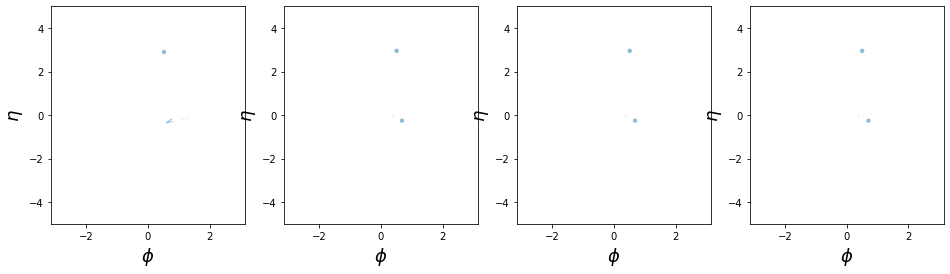

0.0 [3.4868476e-04 7.1048909e-01 6.0052708e-02]
[9.3335187e-15 4.1562122e-01 8.8882446e-04]
[4.2879321e-08 5.2072167e-01 3.6455036e-05]
[2.9857793e-11 2.4187627e-01 6.1731233e-09]


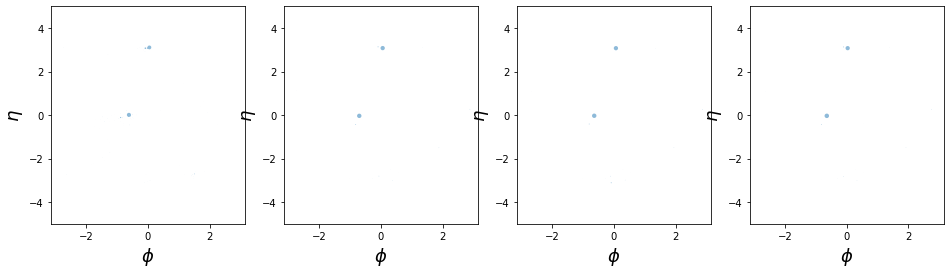

0.0 [0.000365   0.15772961 0.01236264]
[2.9427777e-10 5.4457784e-03 3.8986899e-13]
[4.7110377e-14 7.7437043e-01 9.9079662e-05]
[1.5755584e-06 2.0990729e-02 3.2913562e-07]


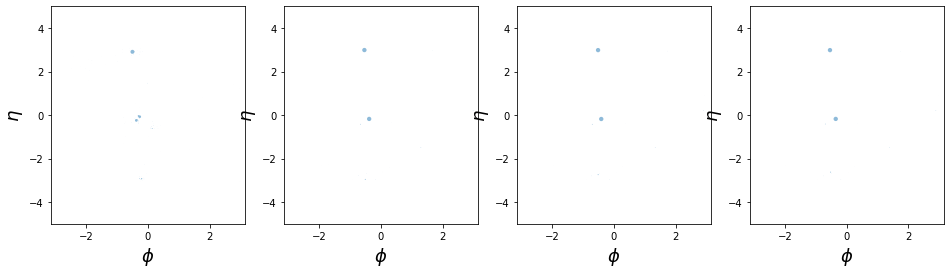

0.0 [0.0004298  0.2356216  0.02454672]
[7.9800028e-11 1.6108453e-03 3.5216264e-05]
[1.0536176e-10 1.4326921e-01 3.9373636e-03]
[4.7689027e-12 2.2937006e-01 7.8601779e-08]


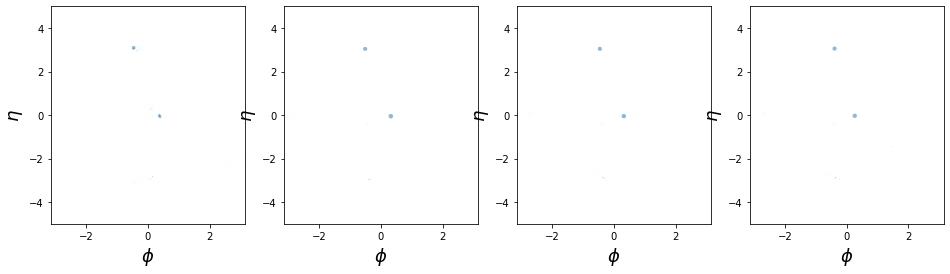

1.0 [4.3349538e-04 5.0071084e-01 3.1741414e-02]
[6.0349267e-11 9.6685529e-01 4.0508166e-05]
[7.6253996e-11 3.6910474e-03 1.3014674e-04]
[6.8129905e-22 4.5356154e-04 1.5551162e-01]


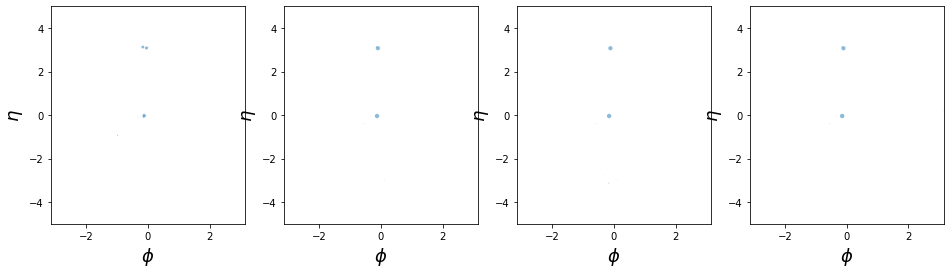

0.0 [4.7482346e-04 5.9814256e-01 4.6304323e-02]
[1.8365010e-12 5.7797790e-01 1.4009774e-03]
[1.9177080e-15 9.9456805e-01 8.3905756e-03]
[1.3410600e-16 9.9995536e-01 9.2708375e-05]


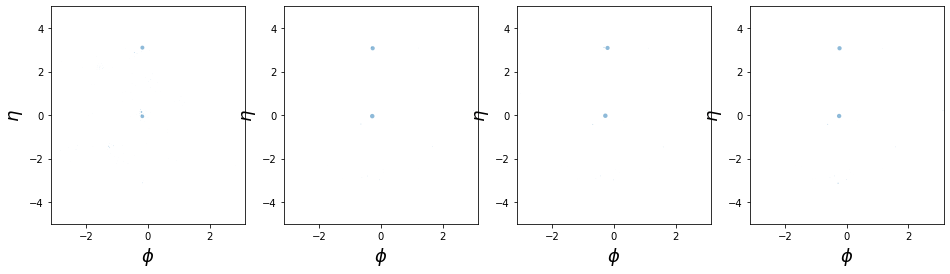

0.0 [5.4085784e-04 7.1892548e-01 6.4929619e-02]
[3.8503067e-10 4.3898821e-04 3.3325079e-05]
[3.6616357e-09 9.0458363e-01 6.2495261e-02]
[1.87389268e-14 9.91264343e-01 1.32761825e-05]


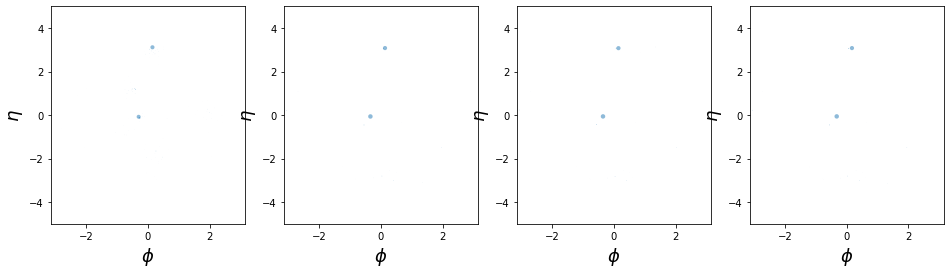

0.0 [0.00073641 0.70164794 0.11707599]
[1.4268435e-08 8.3328897e-01 3.6038756e-03]
[5.0623300e-10 6.8671435e-01 7.1880221e-04]
[4.3158993e-10 9.8807615e-01 8.7322688e-01]


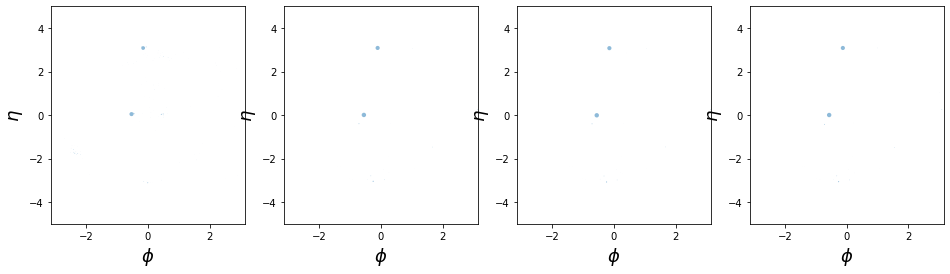

0.0 [0.00082496 0.72058755 0.11983808]
[1.4321002e-08 1.3937888e-01 4.8359525e-01]
[1.5320248e-07 9.0396702e-03 7.9805464e-02]
[9.1602072e-07 4.2722338e-01 6.2936083e-06]


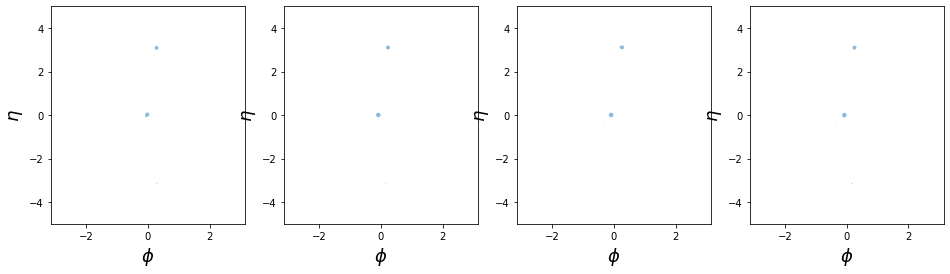

0.0 [0.00085531 0.7470618  0.15327841]
[2.7083340e-12 3.1338930e-02 5.1092924e-05]
[1.9360353e-12 2.0679533e-03 8.9376247e-01]
[9.2442837e-10 5.5750030e-01 1.2366325e-02]


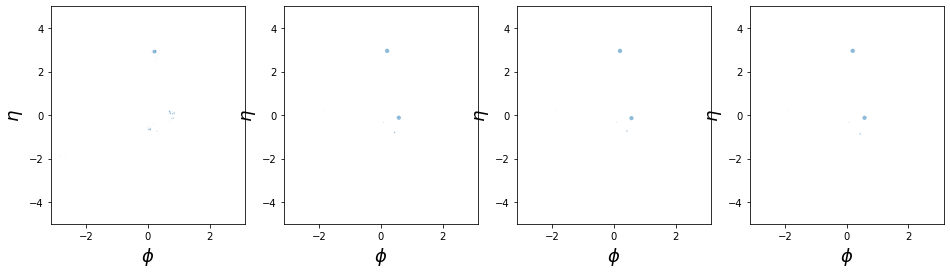

0.0 [0.00087048 0.84360325 0.14589305]
[2.4298301e-11 9.9850613e-01 6.6933751e-02]
[1.9792433e-11 9.9999475e-01 3.2004714e-04]
[2.1753808e-09 9.9773514e-01 4.2029700e-01]


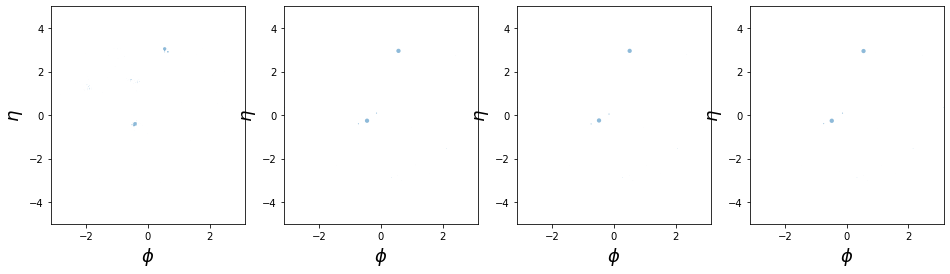

In [22]:
countcut=0.9
etalim=5
#bins=np.linspace(-lim, lim, 126)

for i in bernsort[:50]:   

    fig, ax = plt.subplots(1, 4,figsize=[16,4])

    print(valid_labels[i], p_bern[i][[6,10,15]])

    outjet = valid_y[i,:,1:]
    weights = valid_y[i,:,0]
    pts, phis, etas = get_clustered_pt_phi_eta(weights, outjet,R=0.02)
    ax[0].scatter(phis, etas, s = pts*40, alpha = 0.5,linewidths=0)
    

    #ax[0].hist2d(feed_pc[i][:,0],feed_pc[i][:,1],range=[[-lim,lim],[-lim,lim]],bins=bins, norm=LogNorm(0.5, 1000))
    for j in range(3):
        outjet = outs_array[j][0][i,:,1:]
        weights = outs_array[j][0][i,:,0]
        pred_labels = outs_array[j][-1][i]
        print(pred_labels[[6,10,15]])
        pts, phis, etas = get_clustered_pt_phi_eta(weights, outjet,R=0.02)
        ax[j+1].scatter(phis, etas, s = pts*40, alpha = 0.5,linewidths=0)
#         counts, bx, by = np.histogram2d(np.mod(np.pi+x_outs[j][i,:,0],2*np.pi)-np.pi,x_outs[j][i][:,1],bins=bins,weights=pt_outs[j][i]*100)
#         ax[j+1].imshow(counts.T, norm=LogNorm(countcut,100), origin='lower',cmap='Oranges',extent=[-lim, lim, -lim, lim])
    
    for j in range(4):
        ax[j].set_ylabel(r'$\eta$',fontsize=18)
        ax[j].set_xlabel(r'$\phi$',fontsize=18)
        ax[j].set_ylim([-etalim,etalim])
        ax[j].set_xlim([-np.pi,np.pi])
    
    plt.show()

In [129]:
this[2]

NameError: name 'this' is not defined

In [57]:
history = vae.fit(x=train_x[:200], y=train_y[:200], batch_size=100,
                epochs=epochs,verbose=1,#initial_epoch=history.epoch[-1],
                validation_data = (valid_x[:200],valid_y[:200]),
                callbacks = callbacks
              )

Epoch 1/5
2/2 [==============================] - 0s 40ms/step - loss: -1.5820 - val_loss: 1.4060
Epoch 2/5
2/2 [==============================] - 0s 40ms/step - loss: 1.6568 - val_loss: -3.0890
Epoch 3/5
2/2 [==============================] - 0s 42ms/step - loss: 0.7661 - val_loss: 1.3552
Epoch 4/5
2/2 [==============================] - 0s 39ms/step - loss: 1.7170 - val_loss: 1.5426
Epoch 5/5
2/2 [==============================] - 0s 41ms/step - loss: 1.5745 - val_loss: 1.6897


In [54]:
history.

[2, 3]

In [31]:
valid_y.shape

(78680, 100, 3)

In [34]:
valid_x.shape

(78680, 100, 4)

In [23]:
# https://arxiv.org/pdf/1611.00712.pdf

encoder_conv_layers = [256,256,256,256]
dense_size = 256
decoder = [512,256,256,256]
verbose=0
dropout=0
latent_dim = 128
optimizer=keras.optimizers.Adam()
num_particles_out = 50
sinkhorn_reg = 0.01
numItermax = 20
stopThr=1e-3
adaptive_min = 0.01

temp = 0.3
EPSILON = 1e-6
#renorm_clipping={'rmax':3., 'rmin':1./3, 'dmax':5.}
renorm_clipping = None
momentum = 0.999

def sampling_gauss(args):
    """Reparameterization trick by sampling fr an isotropic unit Gaussian.

    # Arguments
        args (tensor): mean and log of variance of Q(z|X)

    # Returns
        z (tensor): sampled latent vector
    """

    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean=0 and std=1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

def sampling_bern(theta):

    batch = K.shape(theta)[0]
    dim = K.int_shape(theta)[1]
    # by default, random_normal has mean=0 and std=1.0
    epsilon = K.random_uniform(shape=(batch, dim),maxval=1-EPSILON,minval=EPSILON)
    #return (K.log(epsilon) - K.log(1-epsilon) + K.log(theta+EPSILON) - K.log(1-theta+EPSILON))/temp
    return (K.log(epsilon) - K.log(1-epsilon) + K.log(theta+EPSILON))/temp

num_particles = 700

cat_dim = 2

#Encoder
inputs = tf.keras.Input(shape=(num_particles,3,), name='inputs')
beta_input = tf.keras.Input(shape=(1,), name='beta_input')
alpha_input = tf.keras.Input(shape=(1,), name='alpha_input')
#     layer = inputs
#layer = tf.keras.layers.Concatenate()([inputs,beta_input,alpha_input])
#layer = Lambda(lambda x: x[:,:real_dim])(layer)

layer = inputs

for layer_size in encoder_conv_layers:
    layer = Conv1D(layer_size,1,bias_initializer='glorot_uniform')(layer)
#         layer = BatchNormalization(renorm=True,
#                                      renorm_clipping=renorm_clipping,
#                                      momentum = momentum,
#                                      renorm_momentum=momentum)(layer)
    layer = keras.layers.ReLU()(layer)
    if dropout > 0:
        layer = keras.layers.Dropout(dropout)(layer)

# Sum layer
layer = tf.keras.backend.sum(layer,axis=1)

# Dense layers 1
layer = Dense(dense_size)(layer)
layer = keras.layers.ReLU()(layer)
layer = Dense(dense_size)(layer)
layer = keras.layers.ReLU()(layer)

# Cat latent
alpha_bern = Dense(cat_dim, name='alpha_bern')(layer)
#     alpha_bern = BatchNormalization(renorm=True,
#                                      renorm_clipping=renorm_clipping,
#                                      momentum = 0.999,
#                                      renorm_momentum=0.999)(alpha_bern)
alpha_bern = keras.layers.ELU()(alpha_bern)
alpha_bern = keras.layers.Lambda(lambda x: x + 1)(alpha_bern)
#     alpha_bern = Activation('sigmoid')(alpha_bern)


z_bern = Lambda(sampling_bern, output_shape=(cat_dim,), name='z_bern')(alpha_bern)
z_bern_sigmoid = Activation('sigmoid')(z_bern)

layer = tf.keras.layers.Concatenate()([layer,z_bern_sigmoid])

# Dense layers 2
layer = Dense(dense_size)(layer)
layer = keras.layers.ReLU()(layer)
layer = Dense(dense_size)(layer)
layer = keras.layers.ReLU()(layer)
    
z_mean = Dense(latent_dim, name='z_mean')(layer)
z_log_var = Dense(latent_dim, name='z_log_var')(layer)
z = Lambda(sampling_gauss, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

encoder = Model([inputs,beta_input,alpha_input], [z_mean, z_log_var, z, alpha_bern, z_bern_sigmoid], name='encoder')
if verbose:
    encoder.summary()
#plot_model(encoder, to_file='CNN-VAE_encoder.png', show_shapes=True)

# Decoder
latent_inputs_gauss = Input(shape=(latent_dim,), name='z_sampling')
latent_inputs_bern = Input(shape=(cat_dim,), name='z_sampling_bern')
layer = tf.keras.layers.Concatenate()([latent_inputs_gauss,latent_inputs_bern])
#layer = latent_inputs

for i, layer_size in enumerate(decoder):
    layer = Dense(layer_size,bias_initializer='glorot_uniform')(layer)
#         layer = BatchNormalization(renorm=True,
#                                      renorm_clipping=renorm_clipping,
#                                      momentum = momentum,
#                                      renorm_momentum=momentum)(layer)
    layer = keras.layers.ReLU()(layer)
    if dropout > 0:
        layer = keras.layers.Dropout(dropout)(layer)
print(layer)            
layer = Dense(num_particles_out*4)(layer)
print(layer)

layer = Reshape((num_particles_out,4))(layer)
print(layer)
layer_pT = layer[:,:,0:1]
print(layer_pT)
layer_pT = tf.keras.layers.Softmax()(layer_pT)
layer_eta = layer[:,:,1:2]
layer_phi = tf.math.atan2(layer[:,:,3],layer[:,:,2])
layer_phi = tf.expand_dims(layer_phi,axis=-1)
decoded = tf.keras.layers.Concatenate()([layer_pT,layer_eta,layer_phi])
print(decoded)


decoder = Model([latent_inputs_gauss,latent_inputs_bern], decoded, name='decoder')
if verbose:
    decoder.summary()
#plot_model(decoder, to_file='CNN-VAE_decoder.png', show_shapes=True)



Tensor("re_lu_59/Identity:0", shape=(None, 256), dtype=float32)
Tensor("dense_44/Identity:0", shape=(None, 200), dtype=float32)
Tensor("reshape_4/Identity:0", shape=(None, 50, 4), dtype=float32)
Tensor("strided_slice_16:0", shape=(None, 50, 1), dtype=float32)
Tensor("concatenate_14/Identity:0", shape=(None, 50, 3), dtype=float32)


In [96]:
decoded 

<tf.Tensor 'concatenate_23/Identity:0' shape=(None, 50, 3) dtype=float32>

In [94]:
layer_pT

<tf.Tensor 'softmax_2/Identity:0' shape=(None, 50, 1) dtype=float32>

In [95]:
layer_eta

<tf.Tensor 'strided_slice_24:0' shape=(None, 50, 1) dtype=float32>

In [16]:
tf.linalg.tr

<tf.Tensor 'inputs_2:0' shape=(None, 100, 700, 3) dtype=float32>

In [20]:
tf.shape(pointsa)[-2]

<tf.Tensor 'strided_slice_2:0' shape=() dtype=int32>

In [6]:
pointsb = inputs[:,:,1:]
pointsa = outputs[:,:,1:]

a_dim = pointsa.shape[-2]
b_dim = pointsb.shape[-2]

In [7]:
amat = tf.tile(tf.expand_dims(pointsa,2),[1,1,b_dim,1])
bmat = tf.tile(tf.expand_dims(pointsb,1),[1,a_dim,1,1])

In [9]:
bmat

<tf.Tensor 'Tile_1:0' shape=(None, 50, 700, 2) dtype=float32>

In [10]:
diffmat = bmat - amat

In [11]:
diffmat

<tf.Tensor 'sub:0' shape=(None, 50, 700, 2) dtype=float32>

In [7]:
experiment_name = '2D_banana'
vae, encoder, decoder = build_and_compile_annealing_vae(optimizer=keras.optimizers.Adam(lr=0.001,clipnorm=0.1))



ValueError: A `Concatenate` layer requires inputs with matching shapes except for the concat axis. Got inputs shapes: [(None, None, 50, 3), (None, 50, 3)]

In [15]:
Reshape

tensorflow.python.keras.layers.core.Reshape

In [71]:
# You are welcome to load a pretrained model
vae.load_weights('mymodel_weights.h5')

ValueError: Shapes (512, 256) and (512,) are incompatible

In [108]:
reduceLR = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1, mode='auto', min_delta=1e-4, cooldown=0, min_lr=0)
earlystop = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=1e-4, patience=5, verbose=0, mode='auto', baseline=None, restore_best_weights=False)
callbacks = [#modelcheckpoint,
             reduceLR,earlystop]

beta = 1e-1
alpha = 1.0

K.set_value(vae.optimizer.lr,1e-5)
epochs = 1000
history = vae.fit(x=[train_data,np.ones(len(train_data))*beta,np.ones(len(train_data))*alpha], y=train_data, batch_size=100,
                epochs=epochs,verbose=1,#initial_epoch=history.epoch[-1],
                validation_data = ([valid_data,np.ones(len(valid_data))*beta,np.ones(len(valid_data))*alpha],valid_data),
                callbacks = callbacks
              )

# tf.saved_model.save(vae, train_output_dir + '/mymodel.hdf5')

Train on 1000000 samples, validate on 100000 samples
Epoch 1/1000
1000000/1000000 [==============================] - 47s 47us/sample - loss: 5.4467 - recon_loss: 0.0118 - get_kl_loss: 3.9512 - get_kl_loss_bern: 0.3162 - val_loss: 5.4089 - val_recon_loss: 0.0109 - val_get_kl_loss: 3.9862 - val_get_kl_loss_bern: 0.3280
Epoch 2/1000
1000000/1000000 [==============================] - 47s 47us/sample - loss: 5.3745 - recon_loss: 0.0104 - get_kl_loss: 4.0093 - get_kl_loss_bern: 0.3299 - val_loss: 5.3612 - val_recon_loss: 0.0103 - val_get_kl_loss: 3.9984 - val_get_kl_loss_bern: 0.3310
Epoch 3/1000
1000000/1000000 [==============================] - 46s 46us/sample - loss: 5.3662 - recon_loss: 0.0102 - get_kl_loss: 4.0106 - get_kl_loss_bern: 0.3314 - val_loss: 5.3478 - val_recon_loss: 0.0103 - val_get_kl_loss: 3.9904 - val_get_kl_loss_bern: 0.3312
Epoch 4/1000
1000000/1000000 [==============================] - 47s 47us/sample - loss: 5.3595 - recon_loss: 0.0101 - get_kl_loss: 4.0123 - get_kl_lo

In [109]:
vae.save_weights('mymodel_weights_2.h5')

Latent space encoding for beta = 0.18 :


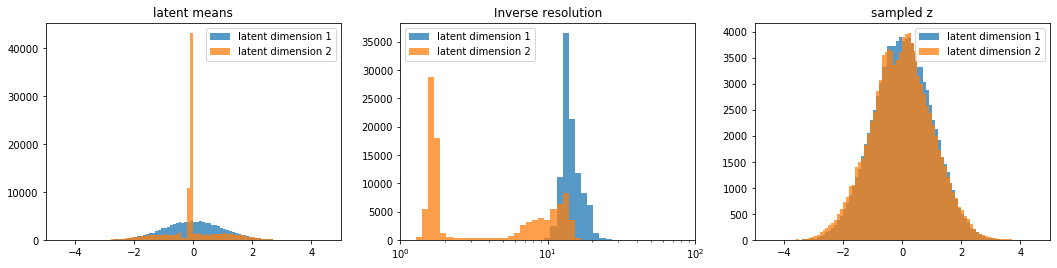

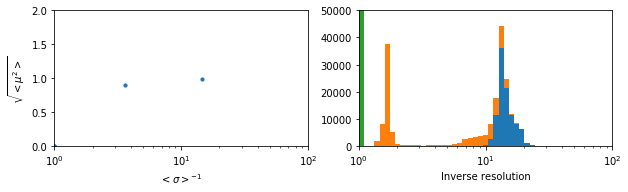

[0.35532367 0.501202  ]
[0.96436054 0.02042921]
categories =  [1, 1]


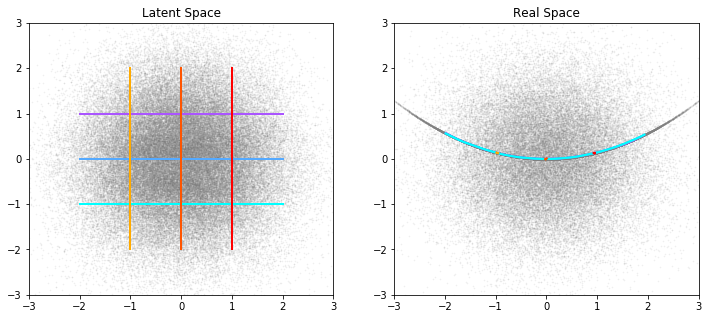

categories =  [1, 0]


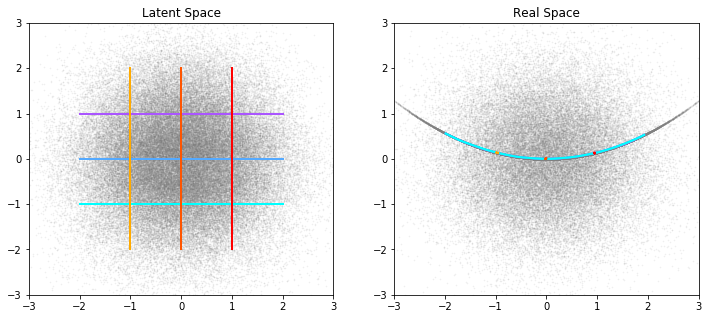

categories =  [0, 0]


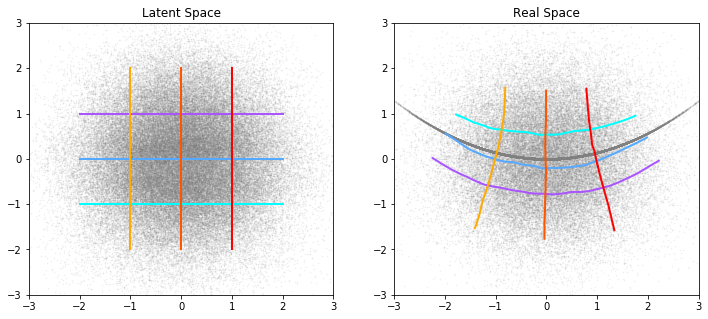

categories =  [0, 1]


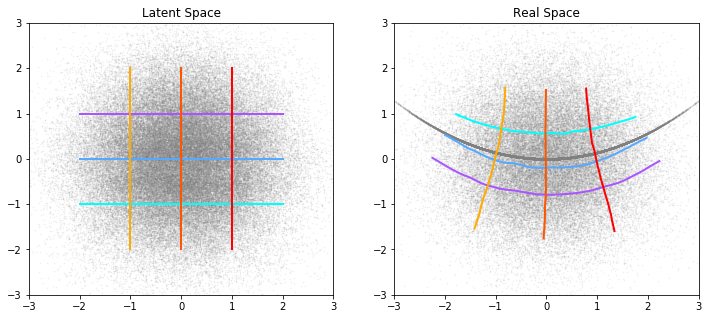

In [143]:
vae.load_weights('mymodel_weights_2.h5')
beta = 0.18

print("Latent space encoding for beta =",beta,":")
myencoder = encoder_class(encoder)
    
plot_latent_space(myencoder,valid_data,xrange = [1,1e2])
plot_latent_space_2(myencoder,valid_data,xrange = [1,1e2])

myencoder = encoder_class(encoder)
z_mu, z_logvar, z, theta, sig = myencoder.predict(valid_data)
print(np.mean(sig,axis=-2))
print(np.std(theta,axis=-2))

for cats in [[1,1],[1,0],[0,0],[0,1]]:
    print("categories = ", cats)
    plot_latent_map(myencoder, decoder, valid_data,
                    cats,
                        scales = np.array([[-2,2],[-2,2]]),
                        values = np.array([[1,0,-1],[1,0,-1]]),
                        latent_plotrange = [-3,3])

# print("categories = ", cats)

# plot_latent_map(myencoder, decoder, valid_data,
#                 [1,0],
#                     scales = np.array([[-2,2],[-2,2]]),
#                     values = np.array([[-1,0,1],[-1,0,1]]),
#                     latent_plotrange = [-3,3])

# print("categories = ", cats)

# plot_latent_map(myencoder, decoder, valid_data,
#                 [0,1],
#                     scales = np.array([[-2,2],[-2,2]]),
#                     values = np.array([[-1,0,1],[-1,0,1]]),
#                     latent_plotrange = [-3,3])

# print("categories = ", cats)

# plot_latent_map(myencoder, decoder, valid_data,
#                 [0,0],
#                     scales = np.array([[-2,2],[-2,2]]),
#                     values = np.array([[-1,0,1],[-1,0,1]]),
#                     latent_plotrange = [-3,3])

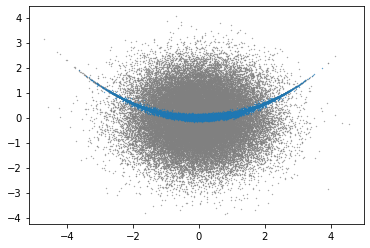

In [121]:
banana_ids = np.where(sig[:,0] > 0.5)
not_banana_ids = np.where(sig[:,0] <= 0.5)
banana = valid_data[banana_ids]
not_banana = valid_data[not_banana_ids]
plt.scatter(not_banana[:,0],not_banana[:,1],s=0.1,color='gray')
plt.scatter(banana[:,0],banana[:,1],s=0.1)

Latent space encoding for beta = 0.18 :


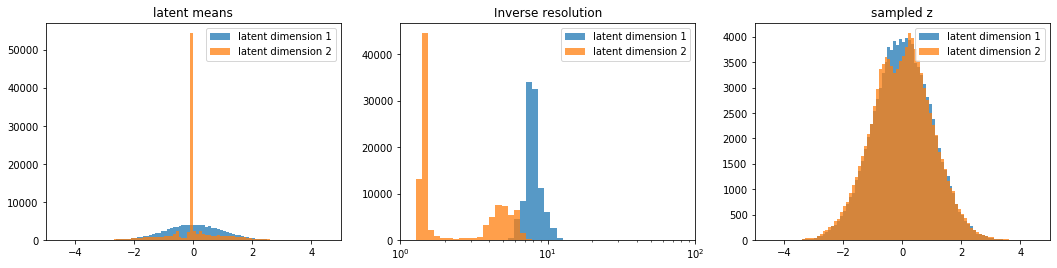

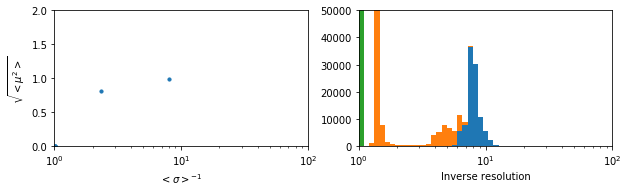

[0.38904503 0.50221467]
[0.9156216  0.01675496]


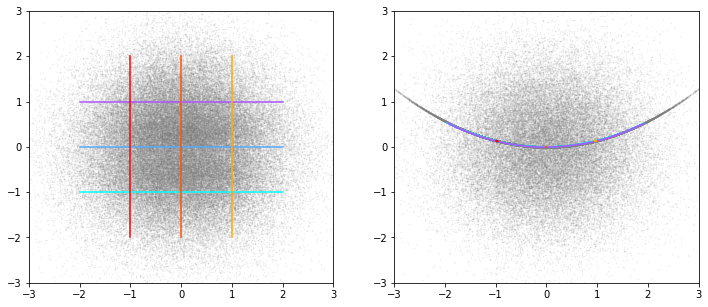

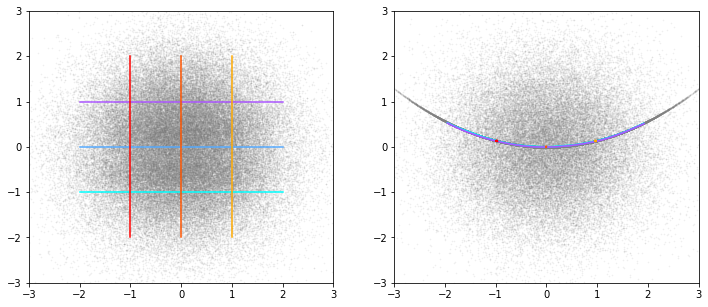

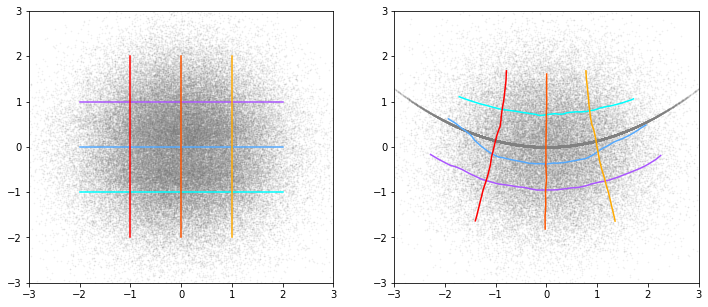

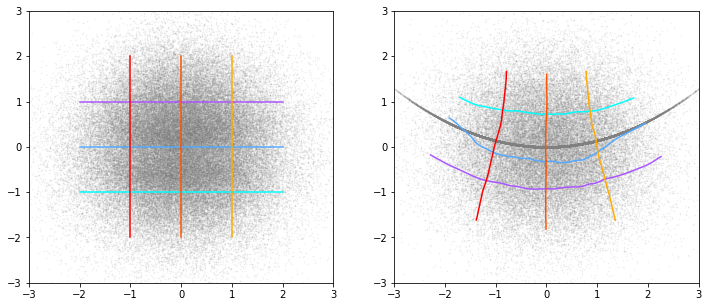

In [107]:
vae.load_weights('mymodel_weights_1.h5')
beta = 0.18

print("Latent space encoding for beta =",beta,":")
myencoder = encoder_class(encoder)
    
plot_latent_space(myencoder,valid_data,xrange = [1,1e2])
plot_latent_space_2(myencoder,valid_data,xrange = [1,1e2])

myencoder = encoder_class(encoder)
z_mu, z_logvar, z, theta, sig = myencoder.predict(valid_data)
print(np.mean(sig,axis=-2))
print(np.std(theta,axis=-2))

plot_latent_map(myencoder, decoder, valid_data,
                [1,1],
                    scales = np.array([[-2,2],[-2,2]]),
                    values = np.array([[-1,0,1],[-1,0,1]]),
                    latent_plotrange = [-3,3])

plot_latent_map(myencoder, decoder, valid_data,
                [1,0],
                    scales = np.array([[-2,2],[-2,2]]),
                    values = np.array([[-1,0,1],[-1,0,1]]),
                    latent_plotrange = [-3,3])

plot_latent_map(myencoder, decoder, valid_data,
                [0,1],
                    scales = np.array([[-2,2],[-2,2]]),
                    values = np.array([[-1,0,1],[-1,0,1]]),
                    latent_plotrange = [-3,3])

plot_latent_map(myencoder, decoder, valid_data,
                [0,0],
                    scales = np.array([[-2,2],[-2,2]]),
                    values = np.array([[-1,0,1],[-1,0,1]]),
                    latent_plotrange = [-3,3])

Latent space encoding for beta = 0.3 :


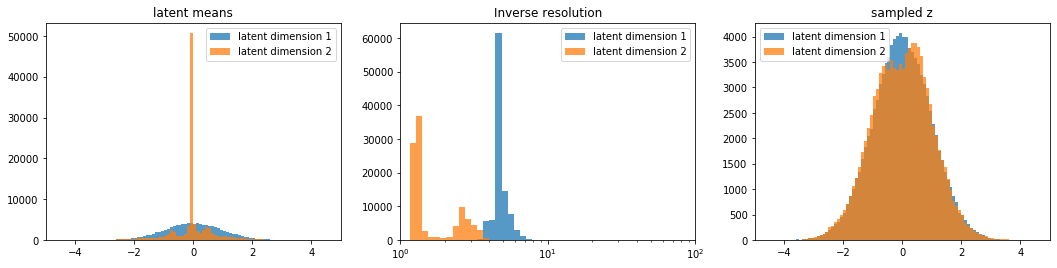

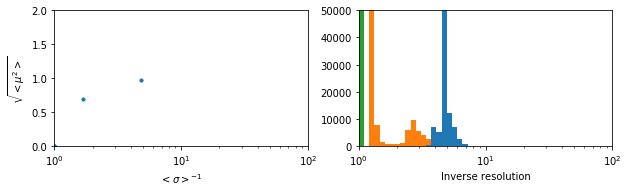

[0.4239141 0.5006592]
[0.8254102  0.02957428]


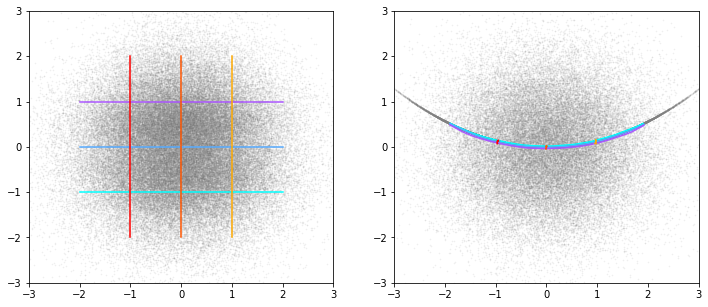

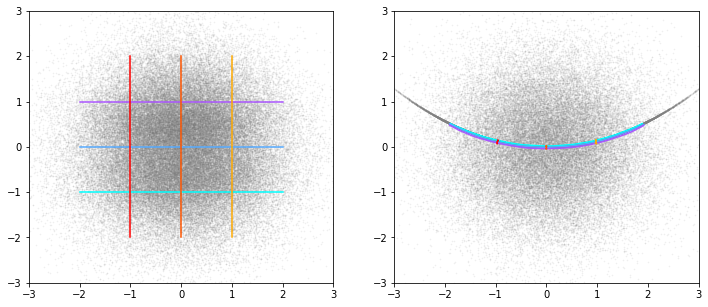

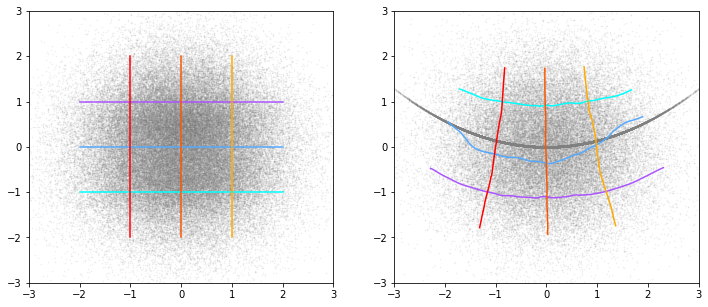

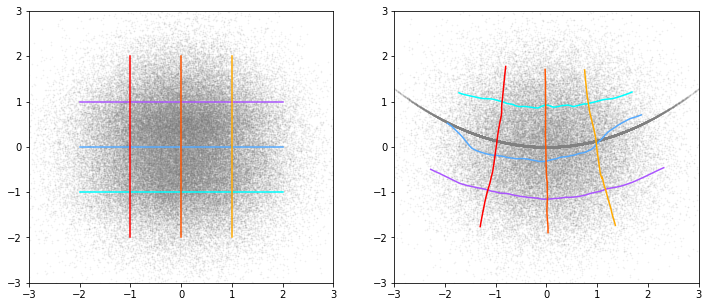

In [102]:
vae.load_weights('mymodel_weights_0.h5')
beta = 0.3

print("Latent space encoding for beta =",beta,":")
myencoder = encoder_class(encoder)
    
plot_latent_space(myencoder,valid_data,xrange = [1,1e2])
plot_latent_space_2(myencoder,valid_data,xrange = [1,1e2])

myencoder = encoder_class(encoder)
z_mu, z_logvar, z, theta, sig = myencoder.predict(valid_data)
print(np.mean(sig,axis=-2))
print(np.std(theta,axis=-2))

plot_latent_map(myencoder, decoder, valid_data,
                [1,1],
                    scales = np.array([[-2,2],[-2,2]]),
                    values = np.array([[-1,0,1],[-1,0,1]]),
                    latent_plotrange = [-3,3])

plot_latent_map(myencoder, decoder, valid_data,
                [1,0],
                    scales = np.array([[-2,2],[-2,2]]),
                    values = np.array([[-1,0,1],[-1,0,1]]),
                    latent_plotrange = [-3,3])

plot_latent_map(myencoder, decoder, valid_data,
                [0,1],
                    scales = np.array([[-2,2],[-2,2]]),
                    values = np.array([[-1,0,1],[-1,0,1]]),
                    latent_plotrange = [-3,3])

plot_latent_map(myencoder, decoder, valid_data,
                [0,0],
                    scales = np.array([[-2,2],[-2,2]]),
                    values = np.array([[-1,0,1],[-1,0,1]]),
                    latent_plotrange = [-3,3])